In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.959572 32: 0.948190 64: 0.965508
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.351762 32: 0.316953 64: 0.293313
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.293750 32: 0.287353 64: 0.280313
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.276981 32: 0.273994 64: 0.272688
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.277198 32: 0.270638 64: 0.271239
Test set:
16: loss: 0.2642	pho_loss: 0.0032
32: loss: 0.2619	pho_loss: 0.0032
64: loss: 0.2626	pho_loss: 0.0032

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.261944 32: 0.258683 64: 0.259053
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.287217 32: 0.284150 64: 0.285502
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.236867 32: 0.235957 64: 0.238659
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.239972 32: 0.241509 64: 0.245249
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.257830 32: 0.253715 64: 0.257455
Test set:
16: loss: 0.2352	pho_loss: 0.0032
32: loss: 0.2353	pho_loss: 0.0032
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.108682 32: 0.089394 64: 0.077952
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.090831 32: 0.070333 64: 0.061136
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.100823 32: 0.082546 64: 0.071697
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.112100 32: 0.086209 64: 0.074330
Test set:
16: loss: 0.0982	pho_loss: 0.0032
32: loss: 0.0802	pho_loss: 0.0032
64: loss: 0.0685	pho_loss: 0.0032

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.085372 32: 0.070528 64: 0.058420
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.084892 32: 0.066828 64: 0.056691
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.098637 32: 0.079612 64: 0.067155
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.096916 32: 0.077184 64: 0.065603
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.108982 32: 0.083545 64: 0.072533
Test set:
16: loss: 0.0956	pho_loss: 0.0032
32: loss: 0.0775	pho_loss: 0.0032
64: loss: 0.0660	pho_loss: 0.0032

Train Epoch: 19 [0/50000 (0%)]	Losses 1

Train Epoch: 33 [12800/50000 (26%)]	Losses 16: 0.086975 32: 0.061410 64: 0.049401
Train Epoch: 33 [25600/50000 (51%)]	Losses 16: 0.080066 32: 0.057626 64: 0.047405
Train Epoch: 33 [38400/50000 (77%)]	Losses 16: 0.073151 32: 0.054228 64: 0.045364
Train Epoch: 33 [12512/50000 (100%)]	Losses 16: 0.081854 32: 0.052139 64: 0.038553
Test set:
16: loss: 0.0780	pho_loss: 0.0031
32: loss: 0.0564	pho_loss: 0.0031
64: loss: 0.0454	pho_loss: 0.0031

Train Epoch: 34 [0/50000 (0%)]	Losses 16: 0.073085 32: 0.050766 64: 0.041637
Train Epoch: 34 [12800/50000 (26%)]	Losses 16: 0.086532 32: 0.061250 64: 0.049387
Train Epoch: 34 [25600/50000 (51%)]	Losses 16: 0.076883 32: 0.055578 64: 0.043945
Train Epoch: 34 [38400/50000 (77%)]	Losses 16: 0.080170 32: 0.055523 64: 0.043958
Train Epoch: 34 [12512/50000 (100%)]	Losses 16: 0.085078 32: 0.061436 64: 0.051524
Test set:
16: loss: 0.0776	pho_loss: 0.0031
32: loss: 0.0556	pho_loss: 0.0031
64: loss: 0.0446	pho_loss: 0.0031

Train Epoch: 35 [0/50000 (0%)]	Losses 1

Train Epoch: 49 [12800/50000 (26%)]	Losses 16: 0.075697 32: 0.046870 64: 0.036315
Train Epoch: 49 [25600/50000 (51%)]	Losses 16: 0.068629 32: 0.042243 64: 0.032420
Train Epoch: 49 [38400/50000 (77%)]	Losses 16: 0.069716 32: 0.044122 64: 0.033660
Train Epoch: 49 [12512/50000 (100%)]	Losses 16: 0.072604 32: 0.047473 64: 0.038589
Test set:
16: loss: 0.0727	pho_loss: 0.0031
32: loss: 0.0475	pho_loss: 0.0031
64: loss: 0.0366	pho_loss: 0.0031

Train Epoch: 50 [0/50000 (0%)]	Losses 16: 0.064696 32: 0.042897 64: 0.032046
Train Epoch: 50 [12800/50000 (26%)]	Losses 16: 0.076706 32: 0.048011 64: 0.036596
Train Epoch: 50 [25600/50000 (51%)]	Losses 16: 0.076021 32: 0.052744 64: 0.040460
Train Epoch: 50 [38400/50000 (77%)]	Losses 16: 0.081033 32: 0.052677 64: 0.040517
Train Epoch: 50 [12512/50000 (100%)]	Losses 16: 0.077505 32: 0.054758 64: 0.041012
Test set:
16: loss: 0.0723	pho_loss: 0.0031
32: loss: 0.0472	pho_loss: 0.0031
64: loss: 0.0363	pho_loss: 0.0031



In [9]:
torch.save(models['64'], './model_64_kl_gn2')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [13]:
model = torch.load('./model_64_kl_gn2')

In [14]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 2,  2,  3,  0,  4,  2,  2,  5,  3,  2,  3,  0,  2,  2,
         2,  3,  2,  3,  2,  2,  1,  2,  0,  1,  1,  2,  3,  2,
         3,  2,  0,  2,  3,  3,  2,  4,  1,  2,  1,  1,  3,  2,
         2,  1,  4,  1,  3,  1,  1,  1,  2,  3,  2,  2,  2,  3,
         2,  2,  2,  1,  4,  0,  1,  0])


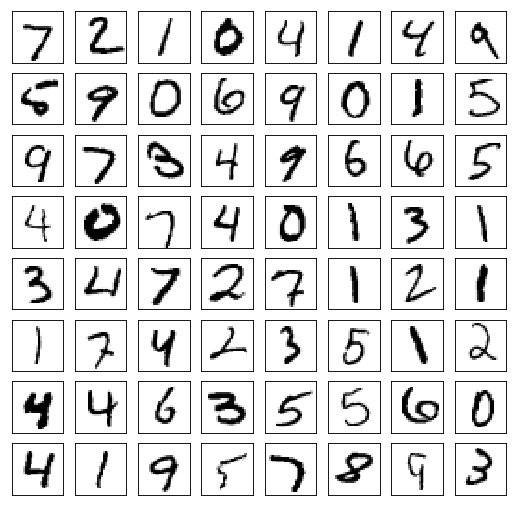

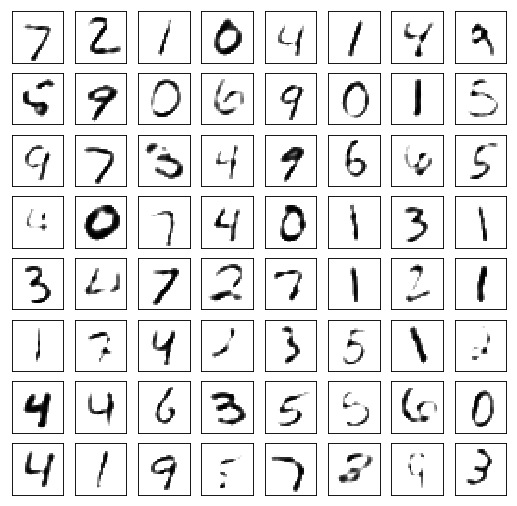

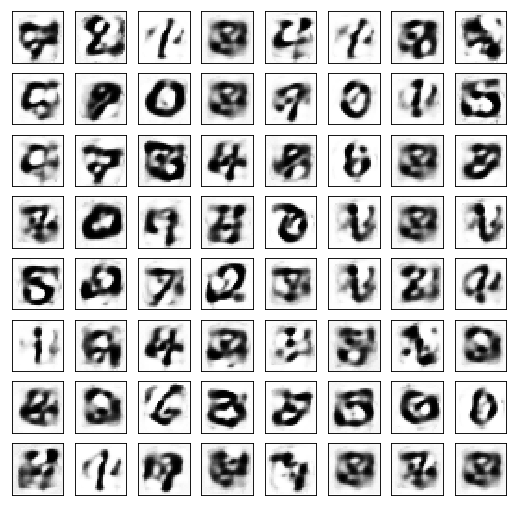

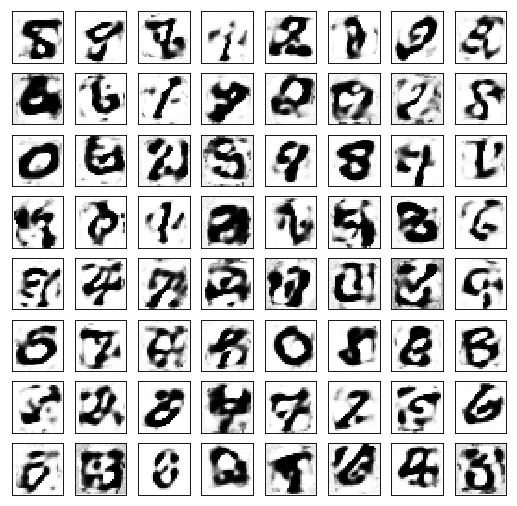

In [15]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [16]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-4, weight_decay=0.)

    for i in range(1, 50000001):  
        
        target = model.E(gen_img_par.view(-1, 28*28))
        
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 20000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображений из батча

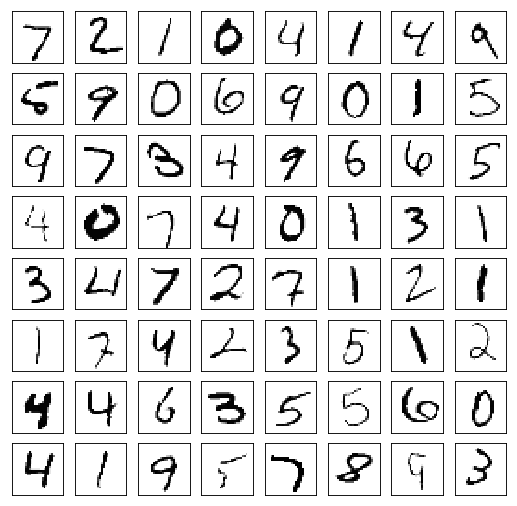

In [17]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.01336218137294054
Iteration 4000: loss=0.007634088862687349
Iteration 6000: loss=0.0038621295243501663
Iteration 8000: loss=0.0023072578478604555
Iteration 10000: loss=0.0015040601138025522
Iteration 12000: loss=0.001034262590110302
Iteration 14000: loss=0.0007497979095205665
Iteration 16000: loss=0.000574692094232887
Iteration 18000: loss=0.0004616608493961394
Iteration 20000: loss=0.0003869564097840339


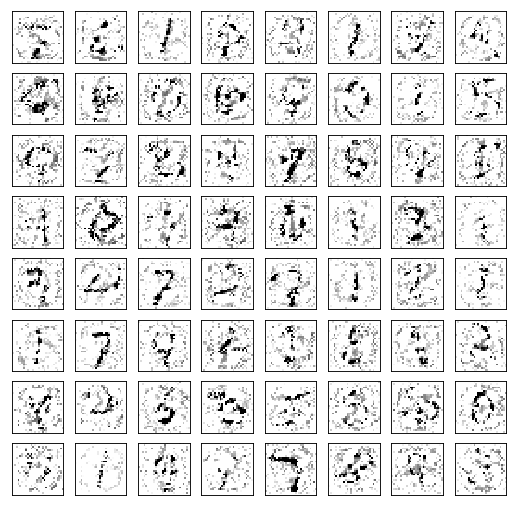

Iteration 22000: loss=0.00033488209010101855
Iteration 24000: loss=0.0002973111695609987
Iteration 26000: loss=0.0002695030707400292
Iteration 28000: loss=0.0002476213267073035
Iteration 30000: loss=0.00023109216999728233
Iteration 32000: loss=0.00021761075186077505
Iteration 34000: loss=0.00020696462888736278
Iteration 36000: loss=0.000198200301383622
Iteration 38000: loss=0.0001907589758047834
Iteration 40000: loss=0.00018449293565936387


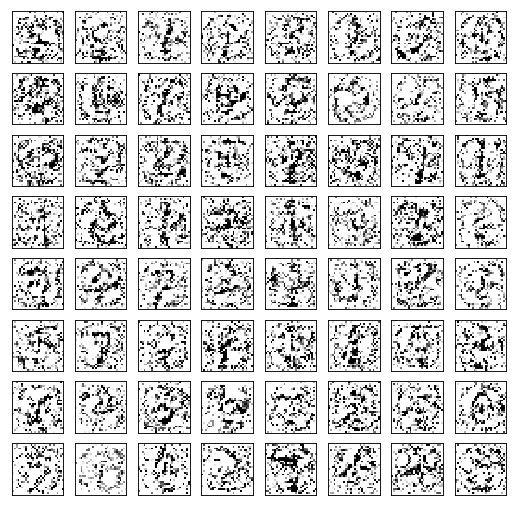

Iteration 42000: loss=0.00017926069267559797
Iteration 44000: loss=0.00017462376854382455
Iteration 46000: loss=0.00017008782015182078
Iteration 48000: loss=0.00016626965953037143
Iteration 50000: loss=0.00016291980864480138
Iteration 52000: loss=0.00015992869157344103
Iteration 54000: loss=0.00015718537906650454
Iteration 56000: loss=0.00015456671826541424
Iteration 58000: loss=0.00015220753266476095
Iteration 60000: loss=0.00015004891611170024


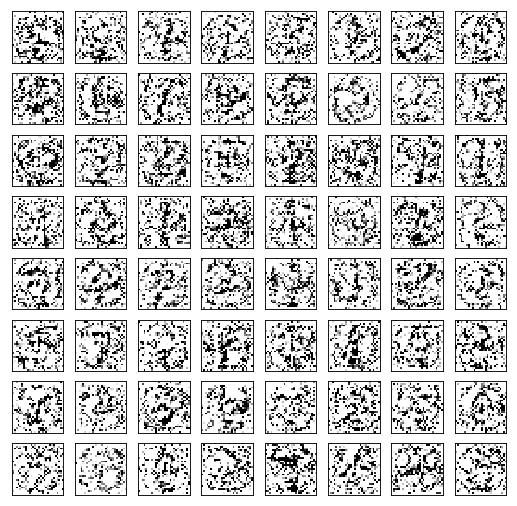

Iteration 62000: loss=0.0001480535138398409
Iteration 64000: loss=0.00014619212015531957
Iteration 66000: loss=0.00014442949031945318
Iteration 68000: loss=0.0001428435352863744
Iteration 70000: loss=0.00014143269800115377
Iteration 72000: loss=0.00014017806097399443
Iteration 74000: loss=0.00013906571257393807
Iteration 76000: loss=0.000138047180371359
Iteration 78000: loss=0.0001370840909658
Iteration 80000: loss=0.0001361580507364124


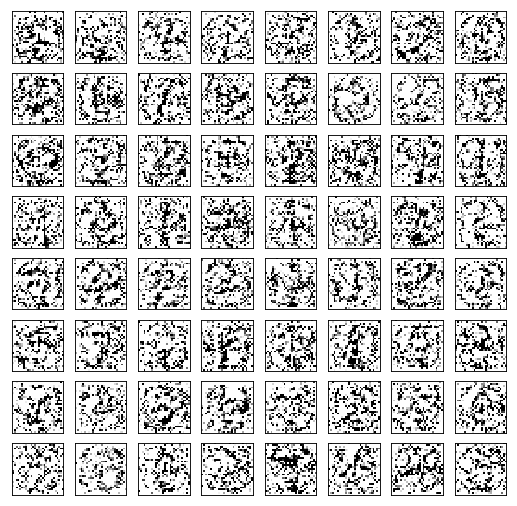

Iteration 82000: loss=0.00013525603571906686
Iteration 84000: loss=0.00013431566185317934
Iteration 86000: loss=0.0001332141982857138
Iteration 88000: loss=0.00013214095088187605
Iteration 90000: loss=0.00013130133447702974
Iteration 92000: loss=0.00013055674207862467
Iteration 94000: loss=0.00012985864304937422
Iteration 96000: loss=0.0001292185188503936
Iteration 98000: loss=0.00012863692245446146
Iteration 100000: loss=0.00012810011685360223


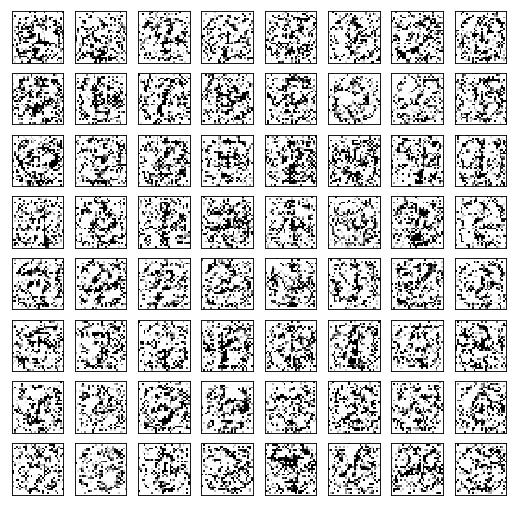

Iteration 102000: loss=0.00012760187382809818
Iteration 104000: loss=0.00012713161413557827
Iteration 106000: loss=0.00012667529517784715
Iteration 108000: loss=0.00012621084169950336
Iteration 110000: loss=0.00012572974083013833
Iteration 112000: loss=0.0001252896909136325
Iteration 114000: loss=0.000124890633742325
Iteration 116000: loss=0.00012451765360310674
Iteration 118000: loss=0.00012416353274602443
Iteration 120000: loss=0.00012382498243823647


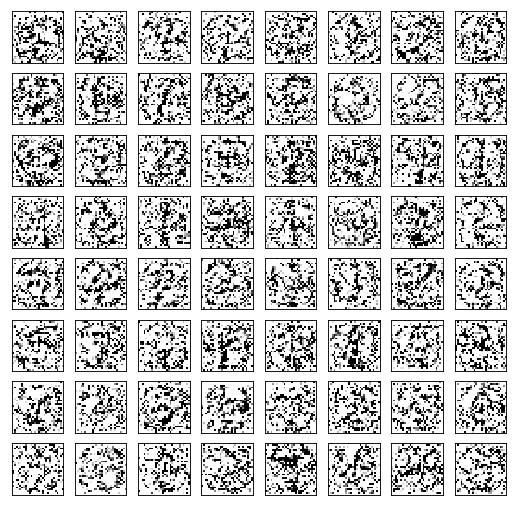

Iteration 122000: loss=0.00012350142060313374
Iteration 124000: loss=0.00012318528024479747
Iteration 126000: loss=0.00012286151468288153
Iteration 128000: loss=0.00012253192835487425
Iteration 130000: loss=0.00012221709766890854
Iteration 132000: loss=0.0001219093901454471
Iteration 134000: loss=0.00012161352060502395
Iteration 136000: loss=0.00012133814016124234
Iteration 138000: loss=0.00012106390931876376
Iteration 140000: loss=0.00012074679398210719


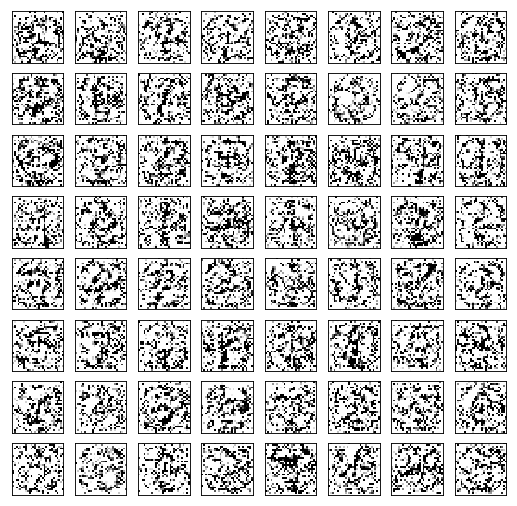

Iteration 142000: loss=0.00012038160639349371
Iteration 144000: loss=0.00012008511112071574
Iteration 146000: loss=0.00011982100113527849
Iteration 148000: loss=0.00011957057722611353
Iteration 150000: loss=0.0001193383868667297
Iteration 152000: loss=0.00011912543413927779
Iteration 154000: loss=0.00011892701149918139
Iteration 156000: loss=0.0001187403904623352
Iteration 158000: loss=0.00011856199125759304
Iteration 160000: loss=0.00011838952923426405


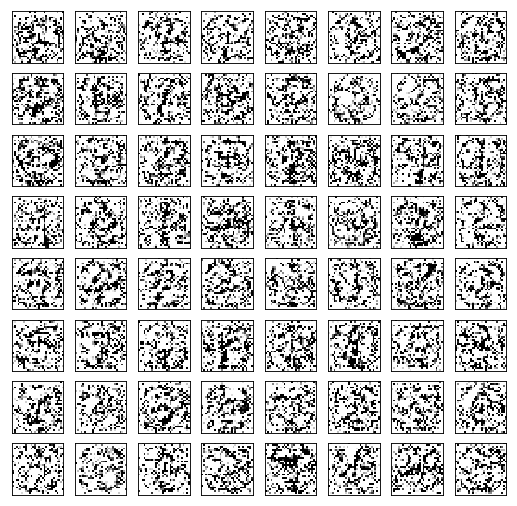

Iteration 162000: loss=0.00011822015221696347
Iteration 164000: loss=0.00011804975656559691
Iteration 166000: loss=0.00011787055700551718
Iteration 168000: loss=0.00011764110968215391
Iteration 170000: loss=0.00011733069550246
Iteration 172000: loss=0.00011709455429809168
Iteration 174000: loss=0.00011689125676639378
Iteration 176000: loss=0.00011669850209727883
Iteration 178000: loss=0.00011651680688373744
Iteration 180000: loss=0.00011634732072707266


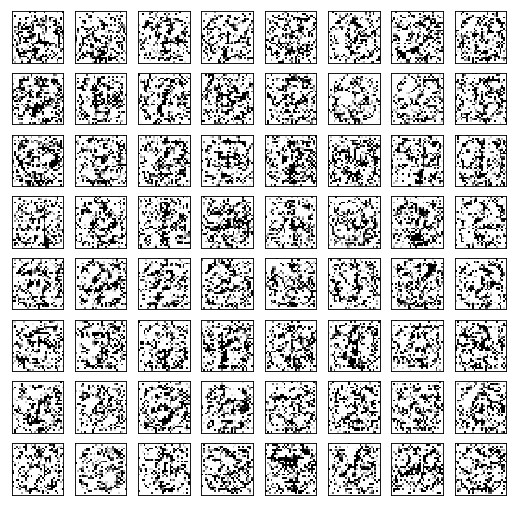

Iteration 182000: loss=0.00011618596181506291
Iteration 184000: loss=0.00011602414451772347
Iteration 186000: loss=0.00011585046740947291
Iteration 188000: loss=0.0001156699363491498
Iteration 190000: loss=0.00011548730253707618
Iteration 192000: loss=0.0001153013072325848
Iteration 194000: loss=0.0001151247342932038
Iteration 196000: loss=0.0001149631425505504
Iteration 198000: loss=0.00011481311958050355
Iteration 200000: loss=0.00011465485295047984


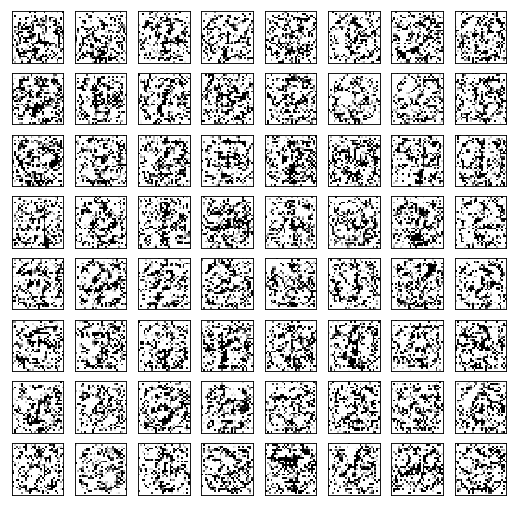

Iteration 202000: loss=0.00011443408584455028
Iteration 204000: loss=0.00011426086712162942
Iteration 206000: loss=0.00011412636376917362
Iteration 208000: loss=0.00011400626681279391
Iteration 210000: loss=0.00011389461724320427
Iteration 212000: loss=0.00011378862836863846
Iteration 214000: loss=0.00011368685227353126
Iteration 216000: loss=0.00011358811025274917
Iteration 218000: loss=0.00011349272244842723
Iteration 220000: loss=0.00011340085620759055


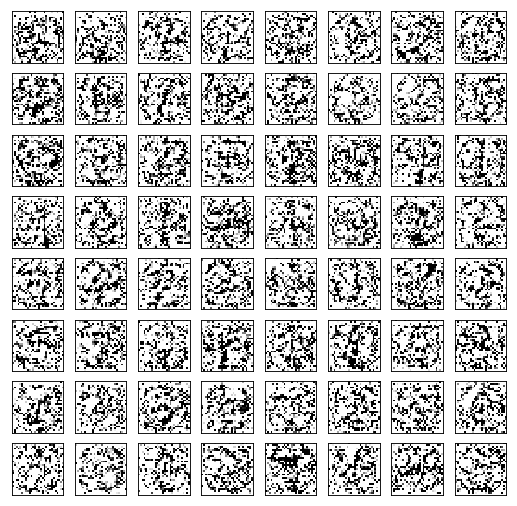

Iteration 222000: loss=0.0001133120822487399
Iteration 224000: loss=0.00011322610225761309
Iteration 226000: loss=0.00011314160656183958
Iteration 228000: loss=0.00011305808584438637
Iteration 230000: loss=0.00011297442688373849
Iteration 232000: loss=0.00011289028770988807
Iteration 234000: loss=0.00011280523904133588
Iteration 236000: loss=0.00011272109986748546
Iteration 238000: loss=0.00011263971828157082
Iteration 240000: loss=0.00011256161087658256


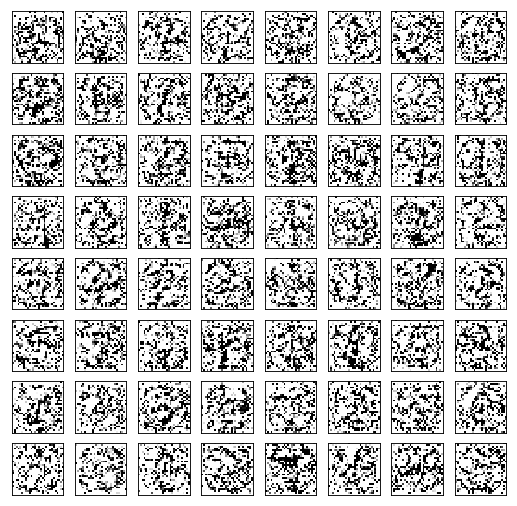

Iteration 242000: loss=0.00011248487862758338
Iteration 244000: loss=0.00011240617459407076
Iteration 246000: loss=0.0001123161637224257
Iteration 248000: loss=0.00011220262240385637
Iteration 250000: loss=0.00011209565855097026
Iteration 252000: loss=0.00011200804146938026
Iteration 254000: loss=0.00011192867532372475
Iteration 256000: loss=0.00011185320181539282
Iteration 258000: loss=0.00011178123531863093
Iteration 260000: loss=0.00011171221558470279


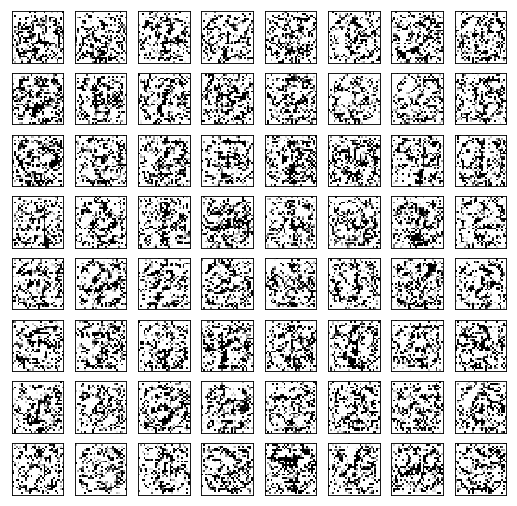

Iteration 262000: loss=0.00011164540774188936
Iteration 264000: loss=0.0001115809500333853
Iteration 266000: loss=0.00011151853686897084
Iteration 268000: loss=0.00011145802272949368
Iteration 270000: loss=0.00011139797425130382
Iteration 272000: loss=0.00011133812222396955
Iteration 274000: loss=0.00011127778998343274
Iteration 276000: loss=0.00011121814895886928
Iteration 278000: loss=0.0001111598321585916
Iteration 280000: loss=0.00011110232298960909


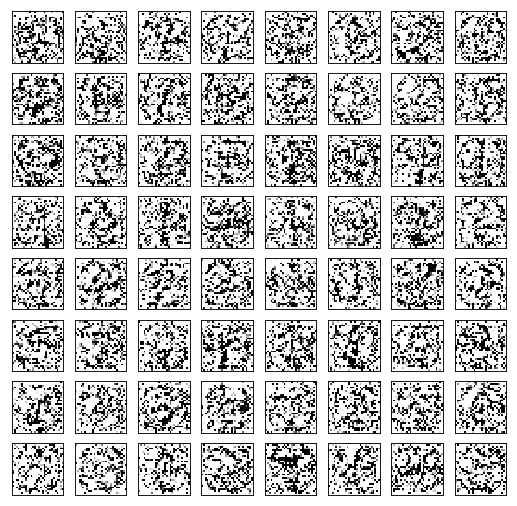

Iteration 282000: loss=0.00011104474106105044
Iteration 284000: loss=0.00011098548566224054
Iteration 286000: loss=0.00011092291970271617
Iteration 288000: loss=0.00011085727601312101
Iteration 290000: loss=0.00011079105024691671
Iteration 292000: loss=0.00011072492634411901
Iteration 294000: loss=0.00011065418220823631
Iteration 296000: loss=0.00011057105439249426
Iteration 298000: loss=0.00011048939632019028
Iteration 300000: loss=0.00011042288679163903


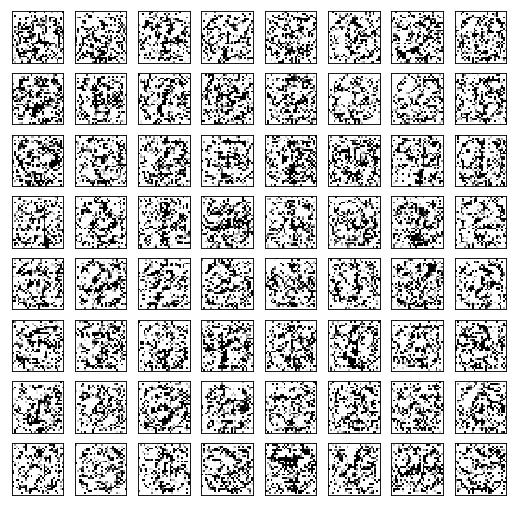

Iteration 302000: loss=0.00011036444630008191
Iteration 304000: loss=0.0001103099129977636
Iteration 306000: loss=0.00011025692947441712
Iteration 308000: loss=0.00011020520469173789
Iteration 310000: loss=0.0001101540619856678
Iteration 312000: loss=0.00011010393063770607
Iteration 314000: loss=0.0001100550580304116
Iteration 316000: loss=0.0001100077060982585
Iteration 318000: loss=0.00010996155469911173
Iteration 320000: loss=0.00010991591989295557


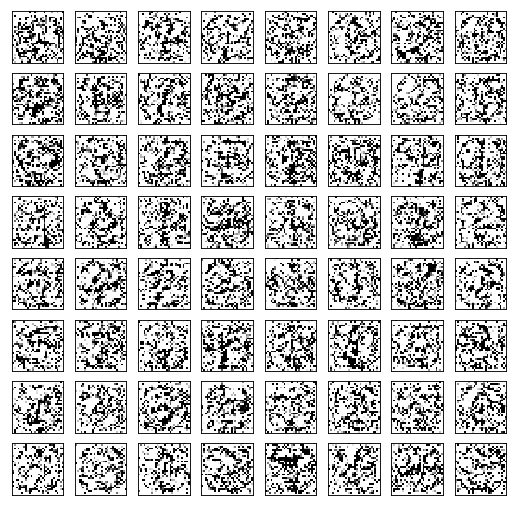

Iteration 322000: loss=0.00010986981214955449
Iteration 324000: loss=0.00010982284584315494
Iteration 326000: loss=0.00010977459896821529
Iteration 328000: loss=0.00010972563904942945
Iteration 330000: loss=0.00010967553680529818
Iteration 332000: loss=0.000109623528260272
Iteration 334000: loss=0.00010957116319332272
Iteration 336000: loss=0.00010952007141895592
Iteration 338000: loss=0.00010947060218313709
Iteration 340000: loss=0.00010942124208668247


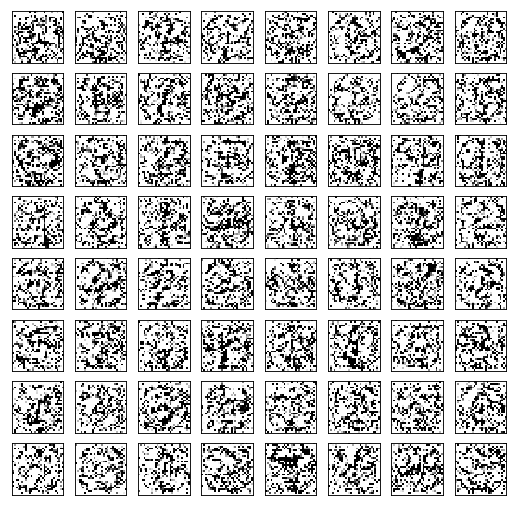

Iteration 342000: loss=0.00010937204206129536
Iteration 344000: loss=0.0001093220489565283
Iteration 346000: loss=0.0001092694146791473
Iteration 348000: loss=0.00010920860222540796
Iteration 350000: loss=0.00010912800644291565
Iteration 352000: loss=0.00010904268128797412
Iteration 354000: loss=0.0001089698780560866
Iteration 356000: loss=0.00010890039266087115
Iteration 358000: loss=0.0001088334247469902
Iteration 360000: loss=0.00010877117165364325


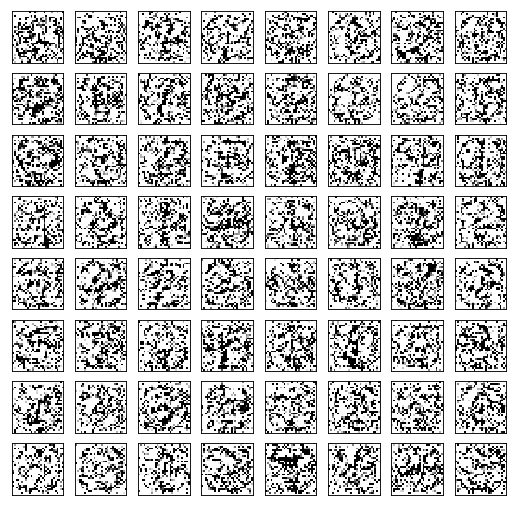

Iteration 362000: loss=0.00010871561244130135
Iteration 364000: loss=0.00010866662341868505
Iteration 366000: loss=0.0001086224292521365
Iteration 368000: loss=0.00010858166206162423
Iteration 370000: loss=0.00010854360152734444
Iteration 372000: loss=0.00010850750550162047
Iteration 374000: loss=0.00010847325756913051
Iteration 376000: loss=0.00010844021016964689
Iteration 378000: loss=0.00010840803588507697
Iteration 380000: loss=0.00010837685113074258


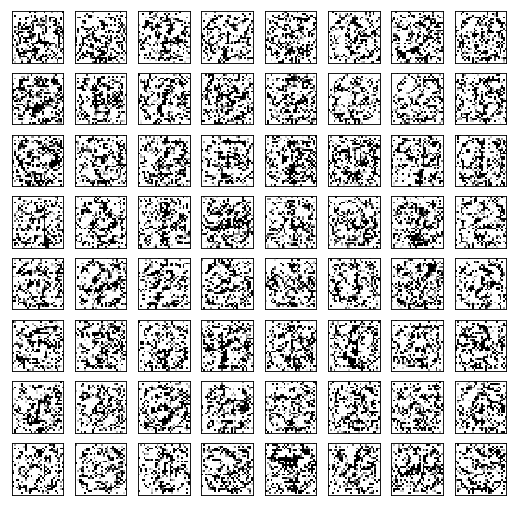

Iteration 382000: loss=0.00010834645217983052
Iteration 384000: loss=0.00010831654799403623
Iteration 386000: loss=0.0001082870367099531
Iteration 388000: loss=0.00010825712524820119
Iteration 390000: loss=0.00010822647891473025
Iteration 392000: loss=0.0001081932132365182
Iteration 394000: loss=0.00010815160203492269
Iteration 396000: loss=0.00010807591024786234
Iteration 398000: loss=0.00010797619324875996
Iteration 400000: loss=0.00010791883687488735


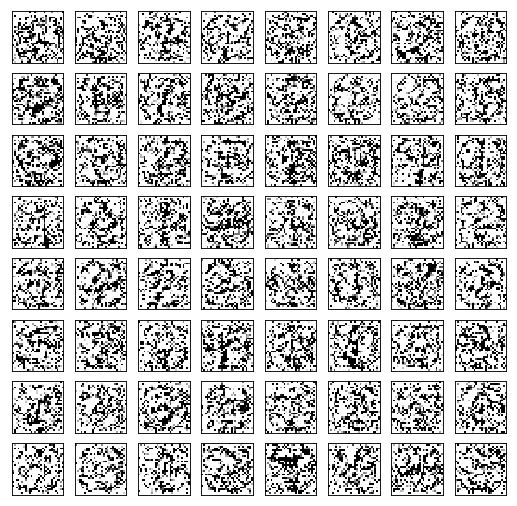

Iteration 402000: loss=0.00010787950304802507
Iteration 404000: loss=0.00010784652113215998
Iteration 406000: loss=0.0001078171917470172
Iteration 408000: loss=0.00010778971773106605
Iteration 410000: loss=0.0001077635824913159
Iteration 412000: loss=0.00010773824760690331
Iteration 414000: loss=0.00010771406959975138
Iteration 416000: loss=0.00010769024083856493
Iteration 418000: loss=0.0001076668850146234
Iteration 420000: loss=0.00010764399485196918


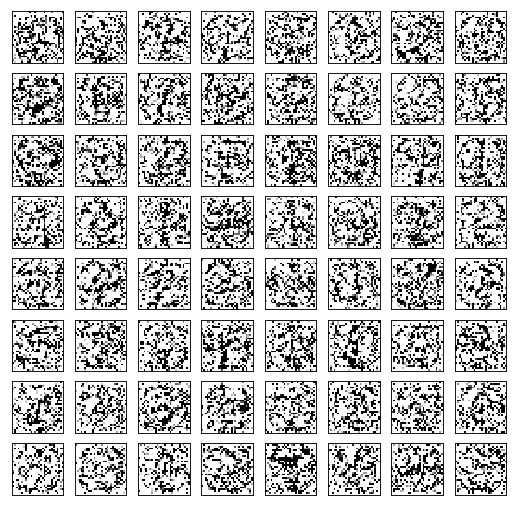

Iteration 422000: loss=0.00010762085730675608
Iteration 424000: loss=0.00010759734141174704
Iteration 426000: loss=0.00010757329437183216
Iteration 428000: loss=0.00010754909453680739
Iteration 430000: loss=0.0001075250911526382
Iteration 432000: loss=0.00010750232468126342
Iteration 434000: loss=0.00010748098429758102
Iteration 436000: loss=0.00010746073530754074
Iteration 438000: loss=0.00010744109022198245
Iteration 440000: loss=0.00010742204176494852


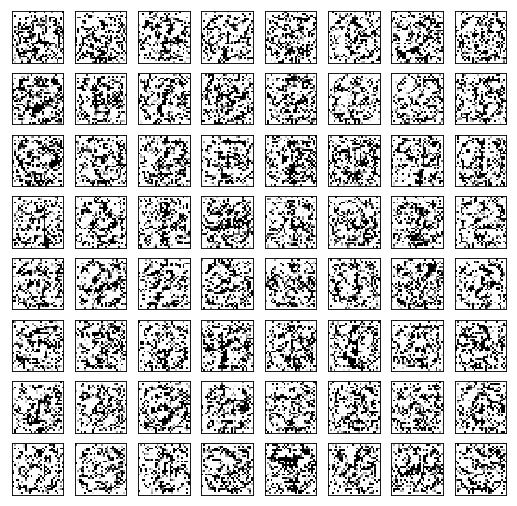

Iteration 442000: loss=0.00010740345896920189
Iteration 444000: loss=0.00010738495620898902
Iteration 446000: loss=0.00010736651165643707
Iteration 448000: loss=0.0001073482635547407
Iteration 450000: loss=0.00010733040835475549
Iteration 452000: loss=0.00010731244401540607
Iteration 454000: loss=0.00010729466157499701
Iteration 456000: loss=0.00010727742483140901
Iteration 458000: loss=0.00010726043547037989
Iteration 460000: loss=0.00010724375897552818


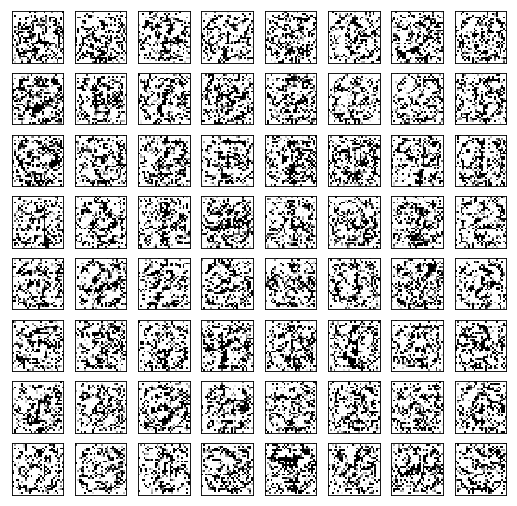

Iteration 462000: loss=0.00010722746810643002
Iteration 464000: loss=0.00010721112630562857
Iteration 466000: loss=0.00010719523561419919
Iteration 468000: loss=0.00010717915574787185
Iteration 470000: loss=0.00010716317046899348
Iteration 472000: loss=0.00010714735253714025
Iteration 474000: loss=0.00010713135998230428
Iteration 476000: loss=0.00010711537470342591
Iteration 478000: loss=0.00010709927300922573
Iteration 480000: loss=0.00010708280751714483


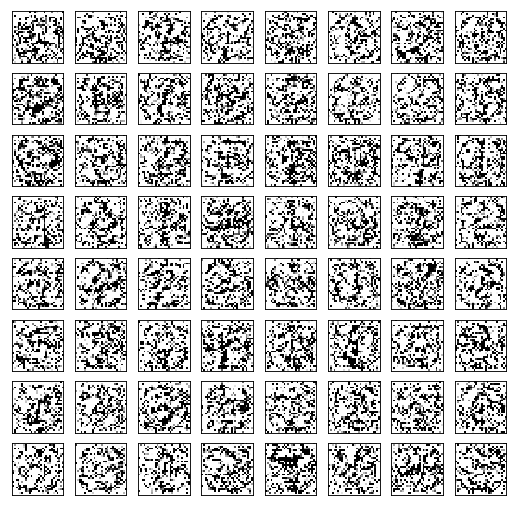

Iteration 482000: loss=0.00010706590546760708
Iteration 484000: loss=0.0001070482685463503
Iteration 486000: loss=0.00010703012230806053
Iteration 488000: loss=0.00010701167775550857
Iteration 490000: loss=0.00010699385165935382
Iteration 492000: loss=0.00010697664401959628
Iteration 494000: loss=0.00010696012759581208
Iteration 496000: loss=0.00010694401862565428
Iteration 498000: loss=0.00010692841897252947
Iteration 500000: loss=0.00010691332863643765


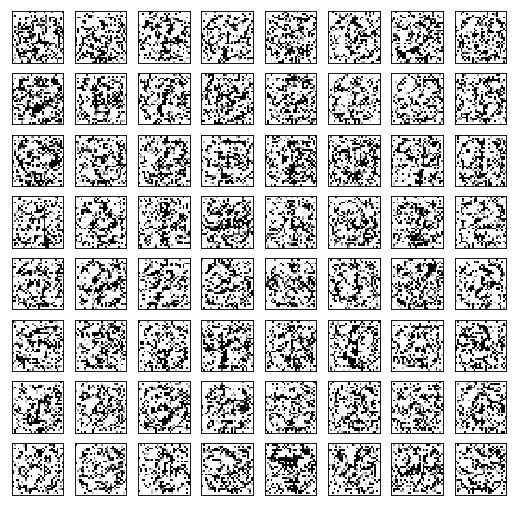

Iteration 502000: loss=0.00010689864575397223
Iteration 504000: loss=0.00010688378097256646
Iteration 506000: loss=0.00010686938185244799
Iteration 508000: loss=0.00010685525921871886
Iteration 510000: loss=0.00010684079461498186
Iteration 512000: loss=0.00010682653373805806
Iteration 514000: loss=0.00010681204730644822
Iteration 516000: loss=0.00010679704428184777
Iteration 518000: loss=0.00010678208491299301
Iteration 520000: loss=0.00010676674719434232


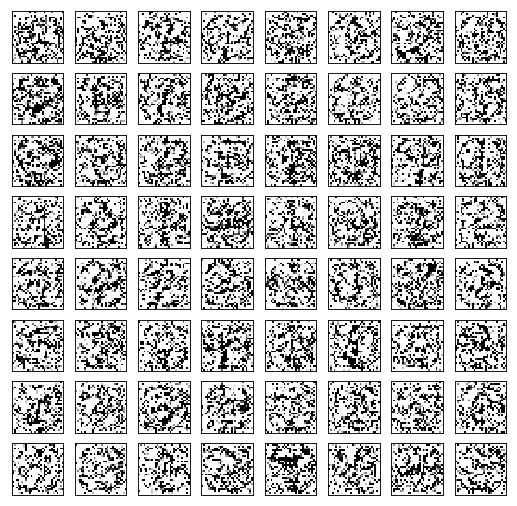

Iteration 522000: loss=0.00010675033990992233
Iteration 524000: loss=0.0001067324701580219
Iteration 526000: loss=0.00010671139170881361
Iteration 528000: loss=0.00010668520553736016
Iteration 530000: loss=0.0001066559852915816
Iteration 532000: loss=0.00010662757267709821
Iteration 534000: loss=0.00010659746476449072
Iteration 536000: loss=0.0001065547694452107
Iteration 538000: loss=0.00010649560863384977
Iteration 540000: loss=0.00010645066504366696


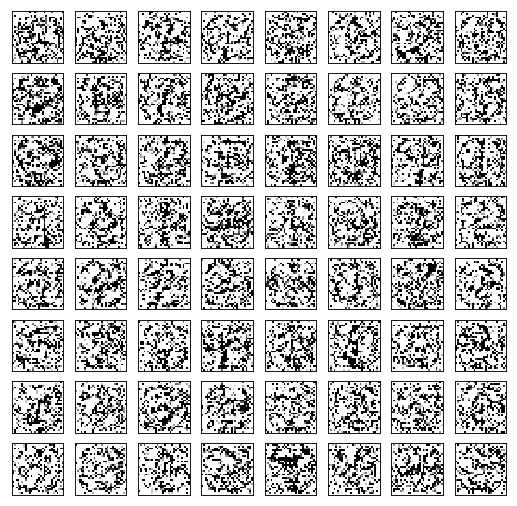

Iteration 542000: loss=0.00010641425615176558
Iteration 544000: loss=0.00010637892410159111
Iteration 546000: loss=0.00010634558566380292
Iteration 548000: loss=0.0001063158706529066
Iteration 550000: loss=0.00010628975724102929
Iteration 552000: loss=0.00010626588482409716
Iteration 554000: loss=0.00010624322749208659
Iteration 556000: loss=0.00010622062836773694
Iteration 558000: loss=0.00010619638487696648
Iteration 560000: loss=0.00010616959480103105


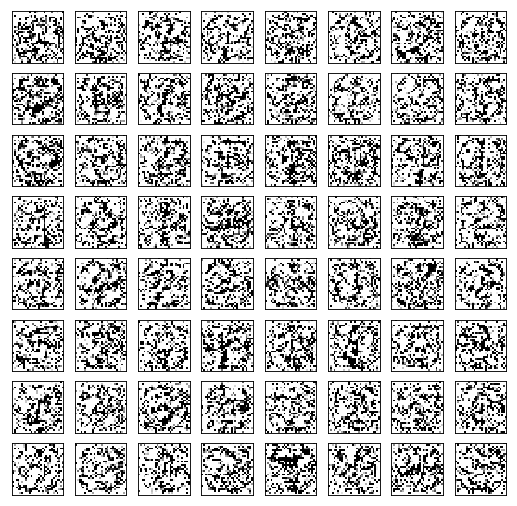

Iteration 562000: loss=0.00010614187340252101
Iteration 564000: loss=0.00010611535253701732
Iteration 566000: loss=0.00010609001037664711
Iteration 568000: loss=0.00010606474825181067
Iteration 570000: loss=0.00010603754344629124
Iteration 572000: loss=0.00010600384121062234
Iteration 574000: loss=0.00010596150968922302
Iteration 576000: loss=0.00010592475882731378
Iteration 578000: loss=0.0001058979905792512
Iteration 580000: loss=0.00010587544238660485


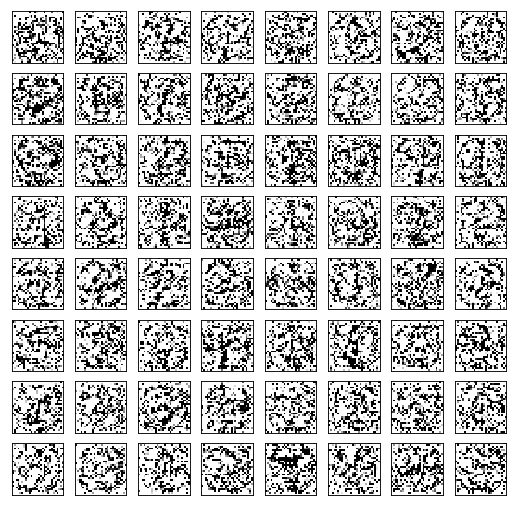

Iteration 582000: loss=0.00010585451673250645
Iteration 584000: loss=0.00010583424591459334
Iteration 586000: loss=0.0001058146808645688
Iteration 588000: loss=0.00010579571244306862
Iteration 590000: loss=0.00010577714419923723
Iteration 592000: loss=0.00010575877240626141
Iteration 594000: loss=0.00010574089537840337
Iteration 596000: loss=0.00010572349128779024
Iteration 598000: loss=0.00010570645099505782
Iteration 600000: loss=0.00010568844299996272


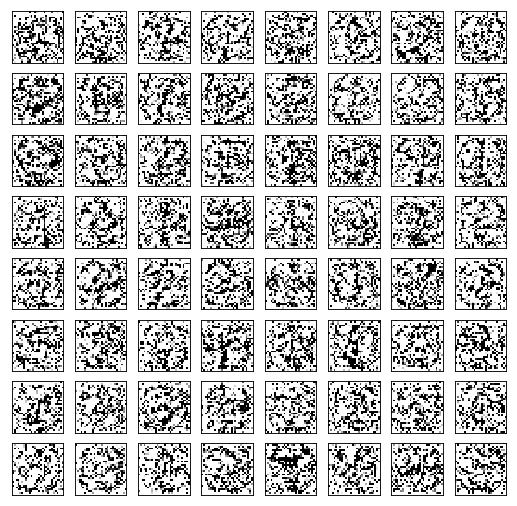

Iteration 602000: loss=0.0001056675537256524
Iteration 604000: loss=0.00010563536488916725
Iteration 606000: loss=0.00010556282359175384
Iteration 608000: loss=0.00010546387056820095
Iteration 610000: loss=0.00010539963841438293
Iteration 612000: loss=0.00010535921319387853
Iteration 614000: loss=0.00010533054592087865
Iteration 616000: loss=0.0001053073865477927
Iteration 618000: loss=0.00010528753773542121
Iteration 620000: loss=0.00010526951518841088


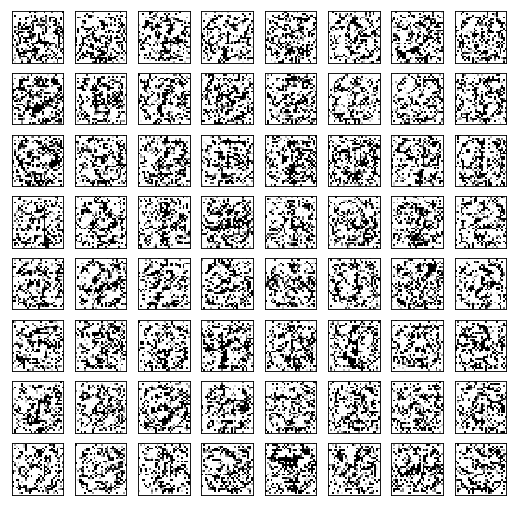

Iteration 622000: loss=0.0001052526495186612
Iteration 624000: loss=0.00010523687524255365
Iteration 626000: loss=0.00010522230149945244
Iteration 628000: loss=0.00010520833166083321
Iteration 630000: loss=0.0001051950894179754
Iteration 632000: loss=0.00010518218186916783
Iteration 634000: loss=0.00010517004557186738
Iteration 636000: loss=0.00010515791655052453
Iteration 638000: loss=0.00010514605673961341
Iteration 640000: loss=0.00010513393499422818


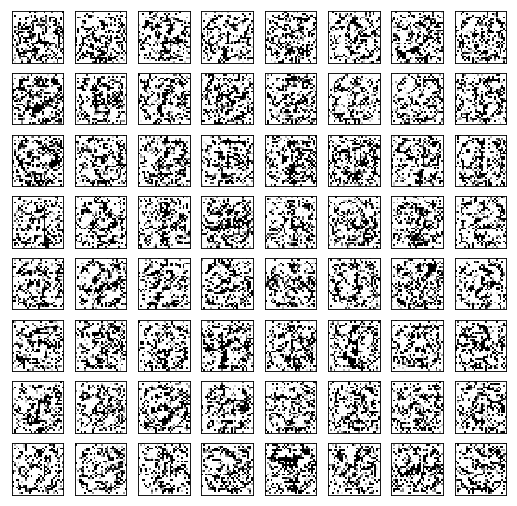

Iteration 642000: loss=0.00010512072185520083
Iteration 644000: loss=0.00010510480933589861
Iteration 646000: loss=0.00010507670958759263
Iteration 648000: loss=0.00010502603254280984
Iteration 650000: loss=0.00010499219206394628
Iteration 652000: loss=0.00010497016046429053
Iteration 654000: loss=0.00010495146852917969
Iteration 656000: loss=0.00010493451554793864
Iteration 658000: loss=0.00010491820285096765
Iteration 660000: loss=0.0001049023267114535


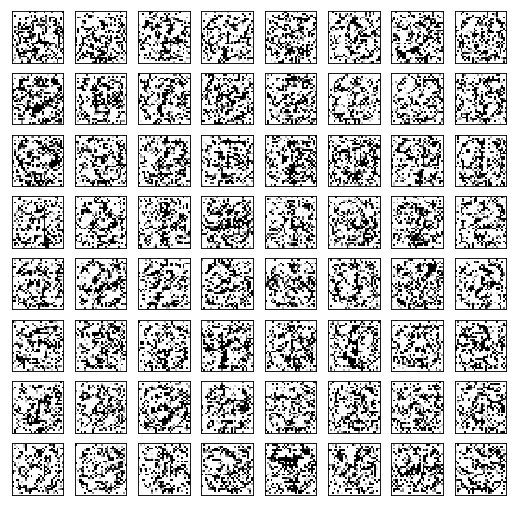

Iteration 662000: loss=0.00010488652333151549
Iteration 664000: loss=0.00010487095278222114
Iteration 666000: loss=0.00010485570965101942
Iteration 668000: loss=0.00010484068479854614
Iteration 670000: loss=0.0001048260455718264
Iteration 672000: loss=0.00010481150093255565
Iteration 674000: loss=0.00010479692718945444
Iteration 676000: loss=0.00010478274634806439
Iteration 678000: loss=0.00010476883471710607
Iteration 680000: loss=0.00010475551971467212


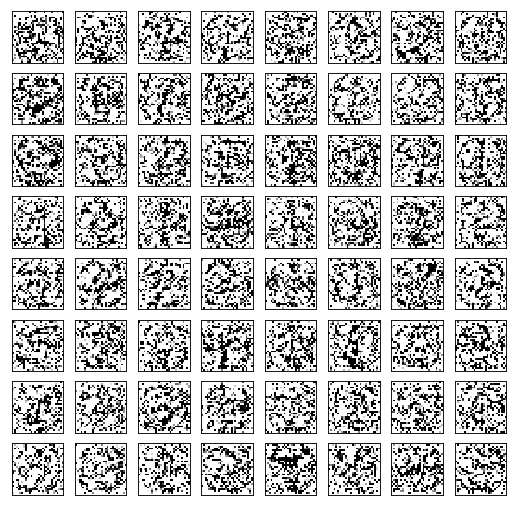

Iteration 682000: loss=0.00010474269947735593
Iteration 684000: loss=0.00010473074507899582
Iteration 686000: loss=0.00010471916903043166
Iteration 688000: loss=0.00010470839333720505
Iteration 690000: loss=0.00010469825065229088
Iteration 692000: loss=0.00010468845721334219
Iteration 694000: loss=0.00010467925312696025
Iteration 696000: loss=0.00010467020911164582
Iteration 698000: loss=0.00010466165258549154
Iteration 700000: loss=0.00010465324157848954


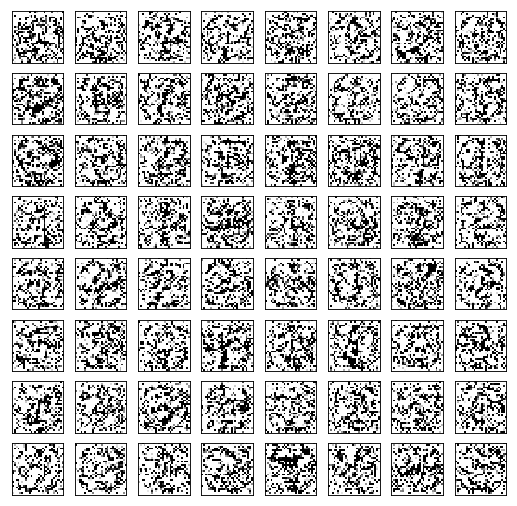

Iteration 702000: loss=0.00010464492515893653
Iteration 704000: loss=0.00010463702346896753
Iteration 706000: loss=0.00010462905629538
Iteration 708000: loss=0.00010462124919285998
Iteration 710000: loss=0.00010461365309311077
Iteration 712000: loss=0.00010460593330208212
Iteration 714000: loss=0.00010459857003297657
Iteration 716000: loss=0.00010459095938131213
Iteration 718000: loss=0.0001045832468662411
Iteration 720000: loss=0.00010457569442223758


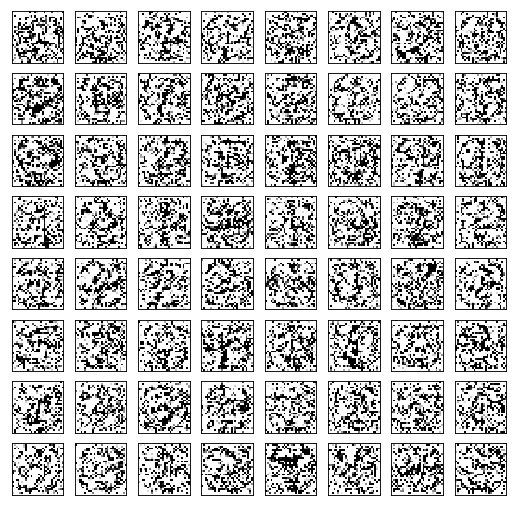

Iteration 722000: loss=0.00010456782183609903
Iteration 724000: loss=0.00010456007294123992
Iteration 726000: loss=0.00010455205483594909
Iteration 728000: loss=0.00010454443690832704
Iteration 730000: loss=0.00010453681170474738
Iteration 732000: loss=0.00010452930291648954
Iteration 734000: loss=0.00010452214337419719
Iteration 736000: loss=0.00010451513662701473
Iteration 738000: loss=0.00010450832633068785
Iteration 740000: loss=0.0001045014796545729


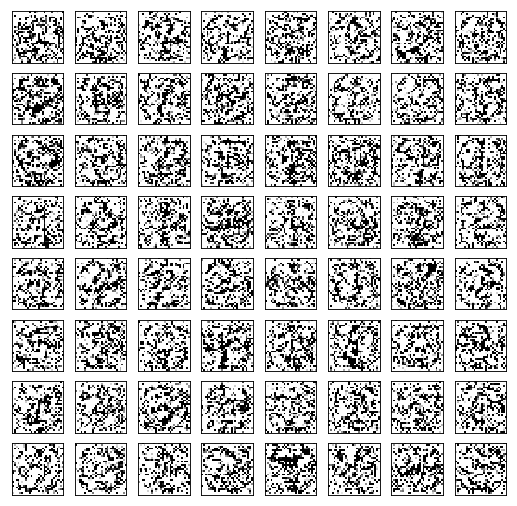

Iteration 742000: loss=0.00010449467663420364
Iteration 744000: loss=0.00010448774992255494
Iteration 746000: loss=0.00010448091052239761
Iteration 748000: loss=0.00010447375825606287
Iteration 750000: loss=0.00010446670785313472
Iteration 752000: loss=0.00010445890802657232
Iteration 754000: loss=0.00010445099178468809
Iteration 756000: loss=0.00010444271174492314
Iteration 758000: loss=0.00010443454812048003
Iteration 760000: loss=0.00010442639177199453


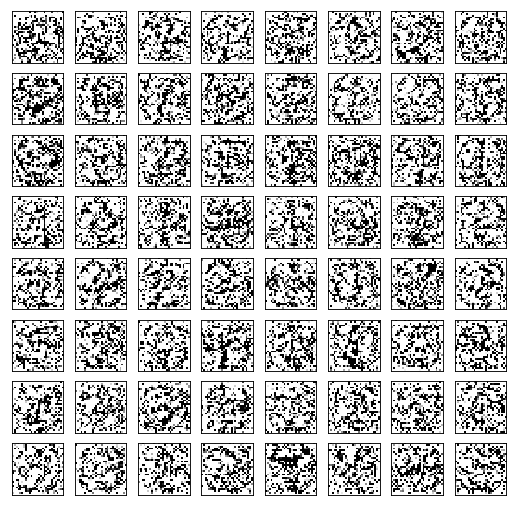

Iteration 762000: loss=0.00010441875201649964
Iteration 764000: loss=0.00010441142512718216
Iteration 766000: loss=0.00010440420010127127
Iteration 768000: loss=0.00010439743346069008
Iteration 770000: loss=0.00010439084144309163
Iteration 772000: loss=0.00010438440949656069
Iteration 774000: loss=0.00010437828314024955
Iteration 776000: loss=0.00010437231685500592
Iteration 778000: loss=0.00010436654702061787
Iteration 780000: loss=0.00010436072625452653


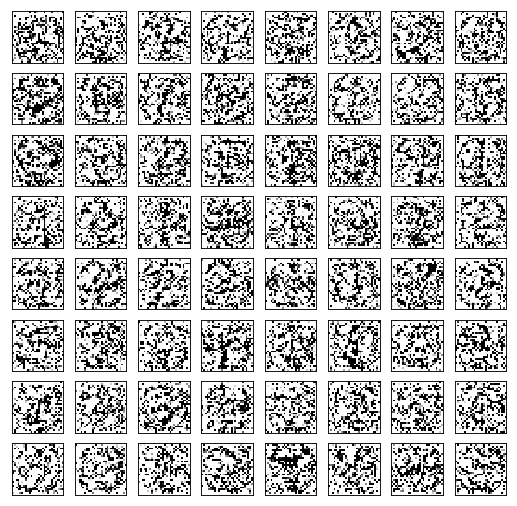

Iteration 782000: loss=0.0001043550728354603
Iteration 784000: loss=0.00010434949945192784
Iteration 786000: loss=0.00010434402793180197
Iteration 788000: loss=0.00010433835268486291
Iteration 790000: loss=0.0001043328593368642
Iteration 792000: loss=0.00010432748240418732
Iteration 794000: loss=0.00010432205453980714
Iteration 796000: loss=0.00010431653936393559
Iteration 798000: loss=0.00010431103873997927
Iteration 800000: loss=0.00010430538532091305


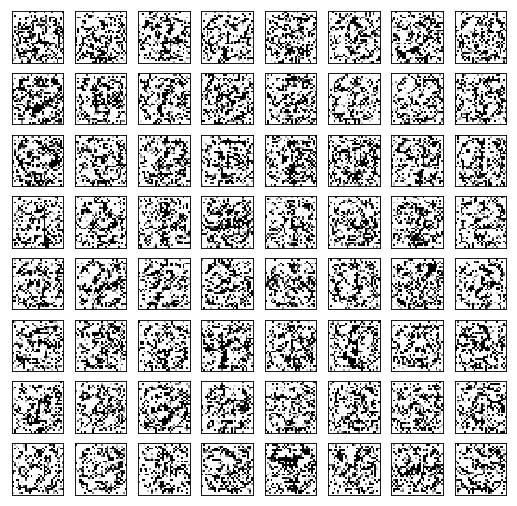

Iteration 802000: loss=0.000104299615486525
Iteration 804000: loss=0.00010429335088701919
Iteration 806000: loss=0.00010428696259623393
Iteration 808000: loss=0.0001042799194692634
Iteration 810000: loss=0.00010427243978483602
Iteration 812000: loss=0.00010426381777506322
Iteration 814000: loss=0.00010425453365314752
Iteration 816000: loss=0.00010424443462397903
Iteration 818000: loss=0.00010423427011119202
Iteration 820000: loss=0.00010422465857118368


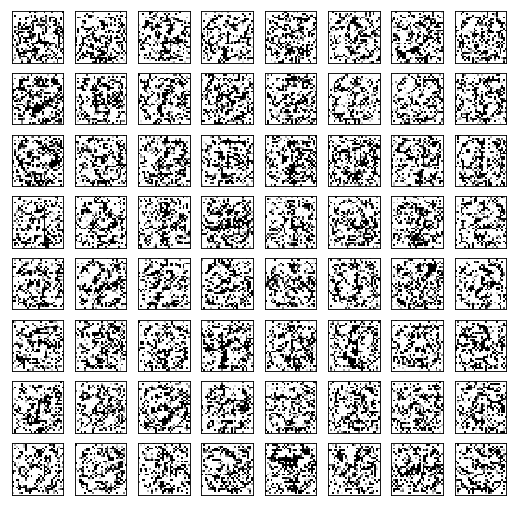

Iteration 822000: loss=0.00010421542538097128
Iteration 824000: loss=0.00010420724720461294
Iteration 826000: loss=0.00010419965110486373
Iteration 828000: loss=0.00010419236059533432
Iteration 830000: loss=0.00010418491729069501
Iteration 832000: loss=0.0001041772193275392
Iteration 834000: loss=0.00010416840814286843
Iteration 836000: loss=0.00010415767610538751
Iteration 838000: loss=0.00010414157441118732
Iteration 840000: loss=0.0001041154027916491


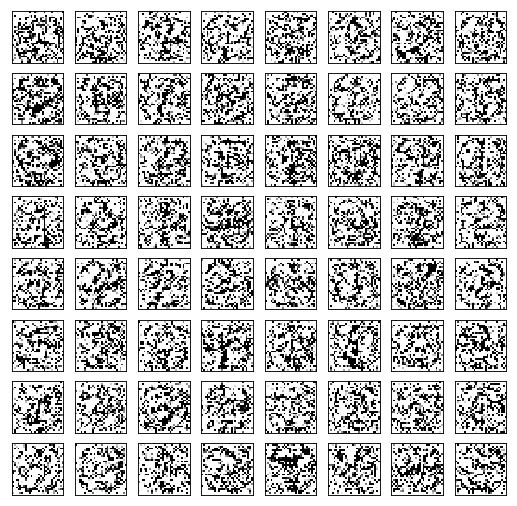

Iteration 842000: loss=0.00010408301750430837
Iteration 844000: loss=0.00010405674402136356
Iteration 846000: loss=0.00010403728811070323
Iteration 848000: loss=0.00010402184125268832
Iteration 850000: loss=0.00010400886822026223
Iteration 852000: loss=0.00010399719030829147
Iteration 854000: loss=0.00010398661106592044
Iteration 856000: loss=0.00010397675941931084
Iteration 858000: loss=0.00010396780271548778
Iteration 860000: loss=0.00010395965364295989


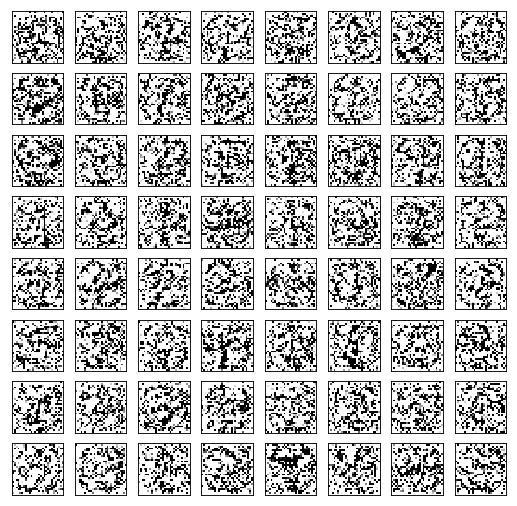

Iteration 862000: loss=0.00010395153367426246
Iteration 864000: loss=0.00010394419223302975
Iteration 866000: loss=0.00010393651609774679
Iteration 868000: loss=0.00010392870899522677
Iteration 870000: loss=0.00010392013791715726
Iteration 872000: loss=0.00010391083924332634
Iteration 874000: loss=0.00010390159150119871
Iteration 876000: loss=0.00010389339877292514
Iteration 878000: loss=0.00010388642840553075
Iteration 880000: loss=0.0001038803457049653


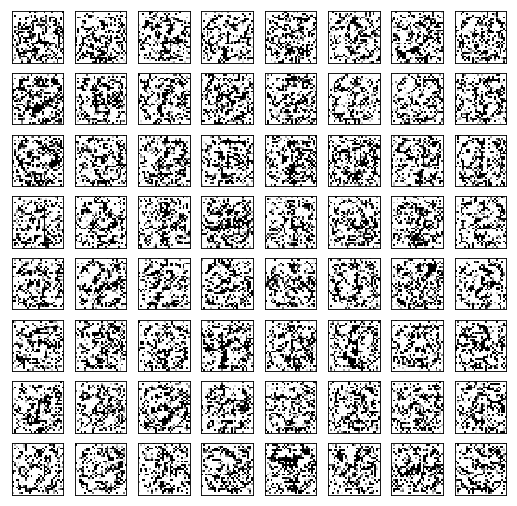

Iteration 882000: loss=0.00010387477232143283
Iteration 884000: loss=0.00010386941721662879
Iteration 886000: loss=0.00010386451322119683
Iteration 888000: loss=0.00010385971108917147
Iteration 890000: loss=0.00010385541099822149
Iteration 892000: loss=0.00010385084169683978
Iteration 894000: loss=0.00010384646884631366
Iteration 896000: loss=0.0001038423361023888
Iteration 898000: loss=0.00010383805056335405
Iteration 900000: loss=0.0001038339250953868


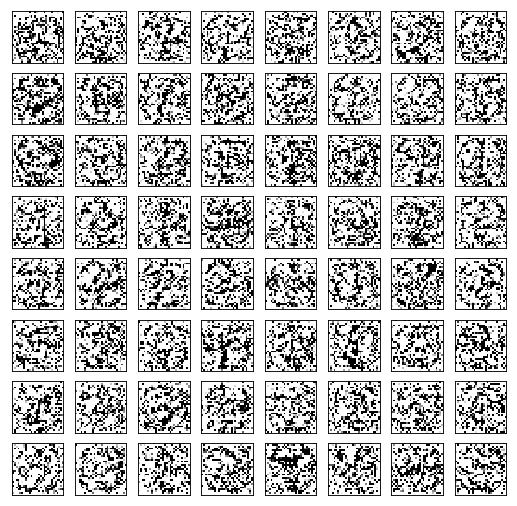

Iteration 902000: loss=0.00010382996697444469
Iteration 904000: loss=0.00010382569598732516
Iteration 906000: loss=0.0001038218688336201
Iteration 908000: loss=0.00010381767060607672
Iteration 910000: loss=0.00010381373431300744
Iteration 912000: loss=0.00010380952153354883
Iteration 914000: loss=0.00010380543244536966
Iteration 916000: loss=0.00010380147432442755
Iteration 918000: loss=0.00010379731247667223
Iteration 920000: loss=0.0001037930414895527


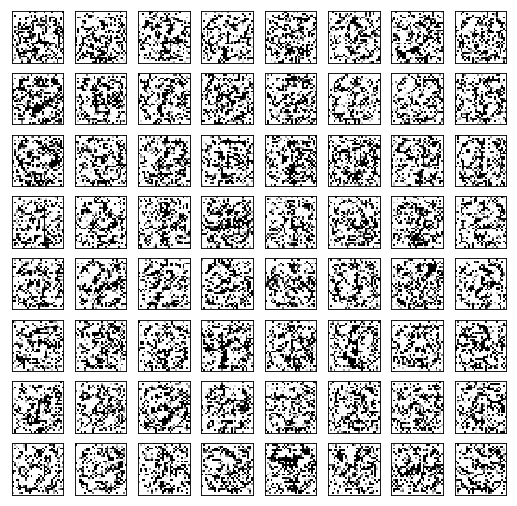

Iteration 922000: loss=0.00010378885053796694
Iteration 924000: loss=0.00010378470324212685
Iteration 926000: loss=0.00010378044680692255
Iteration 928000: loss=0.00010377621947554871
Iteration 930000: loss=0.00010377212311141193
Iteration 932000: loss=0.00010376801947131753
Iteration 934000: loss=0.00010376394493505359
Iteration 936000: loss=0.00010376019054092467
Iteration 938000: loss=0.00010375626152381301
Iteration 940000: loss=0.00010375235433457419


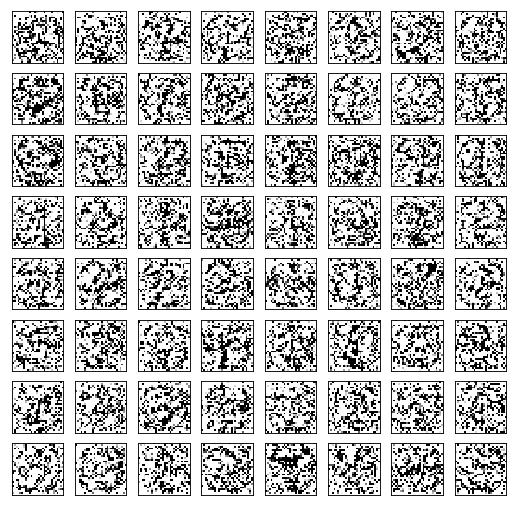

Iteration 942000: loss=0.00010374838166171685
Iteration 944000: loss=0.00010374488192610443
Iteration 946000: loss=0.00010374093108111992
Iteration 948000: loss=0.00010373710392741486
Iteration 950000: loss=0.00010373332042945549
Iteration 952000: loss=0.00010372948599979281
Iteration 954000: loss=0.00010372564429417253
Iteration 956000: loss=0.00010372146061854437
Iteration 958000: loss=0.00010371713142376393
Iteration 960000: loss=0.00010371265670983121


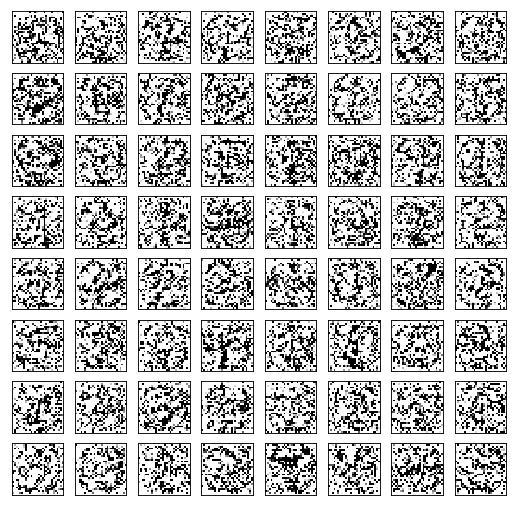

Iteration 962000: loss=0.00010370728705311194
Iteration 964000: loss=0.0001037009060382843
Iteration 966000: loss=0.00010369242227170616
Iteration 968000: loss=0.00010368172661401331
Iteration 970000: loss=0.0001036694084177725
Iteration 972000: loss=0.00010365843627369031
Iteration 974000: loss=0.00010364952322561294
Iteration 976000: loss=0.00010364191984990612
Iteration 978000: loss=0.00010363481123931706
Iteration 980000: loss=0.00010362859029555693


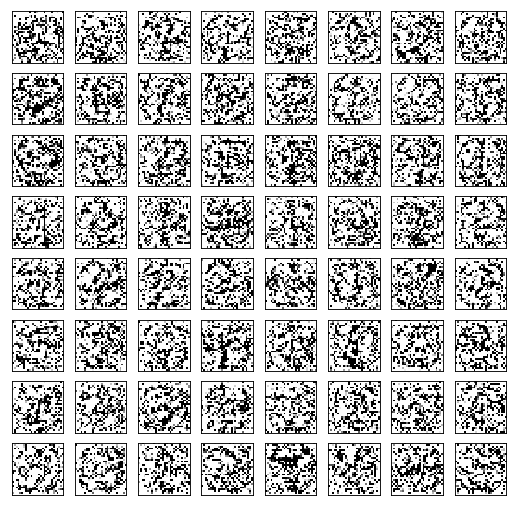

Iteration 982000: loss=0.00010362226748839021
Iteration 984000: loss=0.00010361635941080749
Iteration 986000: loss=0.0001036107714753598
Iteration 988000: loss=0.00010360532905906439
Iteration 990000: loss=0.00010359985026298091
Iteration 992000: loss=0.00010359452426200733
Iteration 994000: loss=0.00010358930740039796
Iteration 996000: loss=0.00010358442523283884
Iteration 998000: loss=0.00010357919381931424
Iteration 1000000: loss=0.00010357428254792467


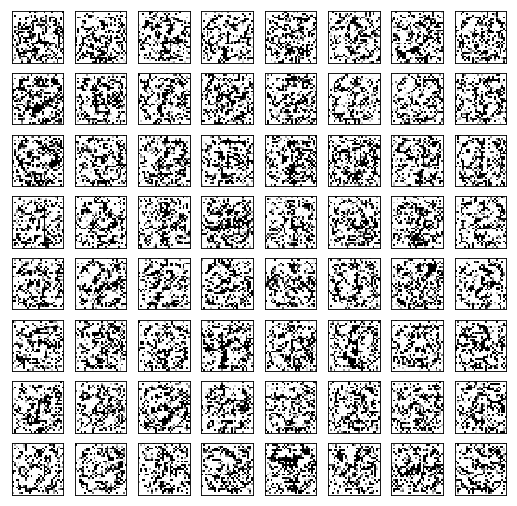

Iteration 1002000: loss=0.00010356914572184905
Iteration 1004000: loss=0.00010356357233831659
Iteration 1006000: loss=0.00010355767153669149
Iteration 1008000: loss=0.00010355079575674608
Iteration 1010000: loss=0.00010354280675528571
Iteration 1012000: loss=0.00010353262041462585
Iteration 1014000: loss=0.00010352093522669747
Iteration 1016000: loss=0.000103509402833879
Iteration 1018000: loss=0.0001034994565998204
Iteration 1020000: loss=0.00010349086369387805


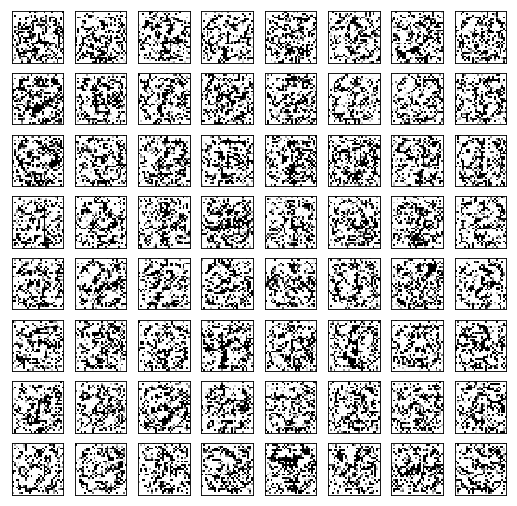

Iteration 1022000: loss=0.00010348358046030626
Iteration 1024000: loss=0.00010347710485802963
Iteration 1026000: loss=0.00010347141505917534
Iteration 1028000: loss=0.00010346627095714211
Iteration 1030000: loss=0.00010346147610107437
Iteration 1032000: loss=0.00010345699411118403
Iteration 1034000: loss=0.00010345294140279293
Iteration 1036000: loss=0.00010344888869440183
Iteration 1038000: loss=0.00010344506154069677
Iteration 1040000: loss=0.00010344143083784729


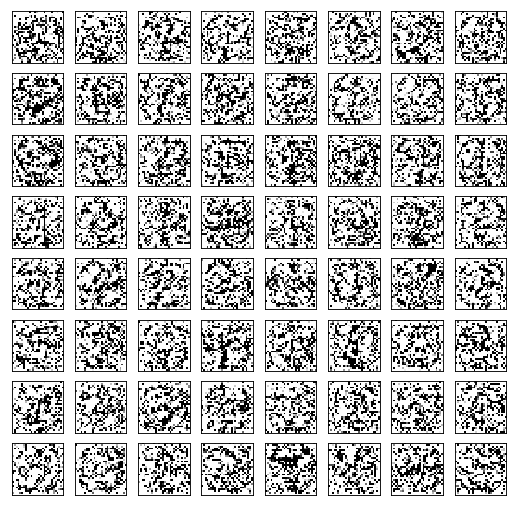

Iteration 1042000: loss=0.00010343790927436203
Iteration 1044000: loss=0.0001034342494676821
Iteration 1046000: loss=0.00010343077155994251
Iteration 1048000: loss=0.00010342762834625319
Iteration 1050000: loss=0.00010342443420086056
Iteration 1052000: loss=0.00010342110908823088
Iteration 1054000: loss=0.00010341795859858394
Iteration 1056000: loss=0.00010341482266085222
Iteration 1058000: loss=0.0001034115775837563
Iteration 1060000: loss=0.00010340850712964311


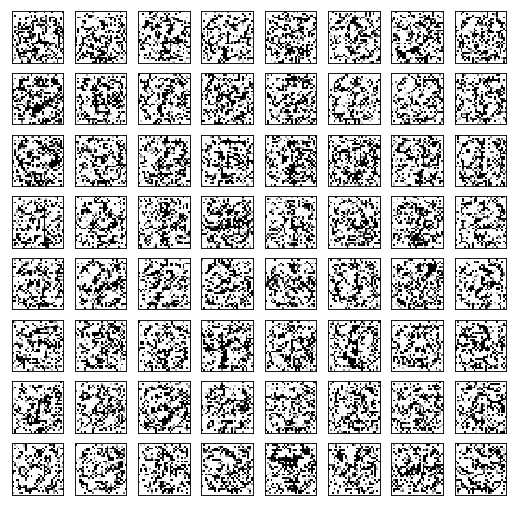

Iteration 1062000: loss=0.00010340517474105582
Iteration 1064000: loss=0.00010340174048906192
Iteration 1066000: loss=0.00010339857544749975
Iteration 1068000: loss=0.00010339517757529393
Iteration 1070000: loss=0.00010339163418393582
Iteration 1072000: loss=0.00010338819993194193
Iteration 1074000: loss=0.00010338449646951631
Iteration 1076000: loss=0.00010338089487049729
Iteration 1078000: loss=0.00010337699495721608
Iteration 1080000: loss=0.00010337316052755341


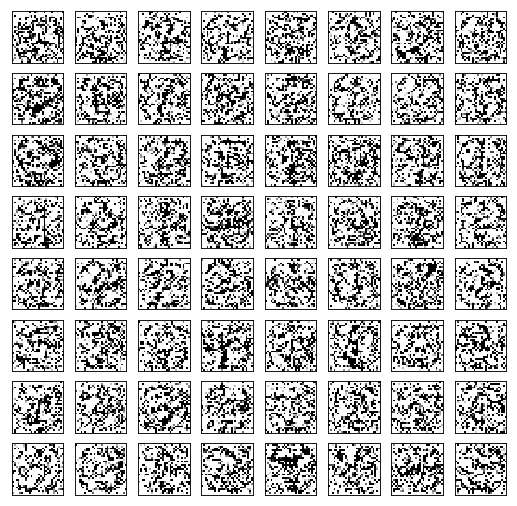

Iteration 1082000: loss=0.00010336909326724708
Iteration 1084000: loss=0.00010336507693864405
Iteration 1086000: loss=0.00010336082777939737
Iteration 1088000: loss=0.00010335675324313343
Iteration 1090000: loss=0.0001033526350511238
Iteration 1092000: loss=0.00010334861144656315
Iteration 1094000: loss=0.00010334471880923957
Iteration 1096000: loss=0.00010334105172660202
Iteration 1098000: loss=0.00010333712998544797
Iteration 1100000: loss=0.00010333363752579316


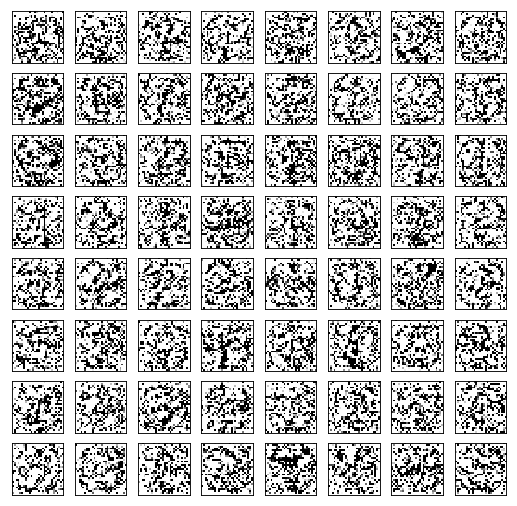

Iteration 1102000: loss=0.00010333033424103633
Iteration 1104000: loss=0.00010332684178138152
Iteration 1106000: loss=0.00010332311649108306
Iteration 1108000: loss=0.00010331933299312368
Iteration 1110000: loss=0.00010331546945963055
Iteration 1112000: loss=0.00010331109660910442
Iteration 1114000: loss=0.00010330627264920622
Iteration 1116000: loss=0.00010330044460715726
Iteration 1118000: loss=0.00010329299402656034
Iteration 1120000: loss=0.00010328298958484083


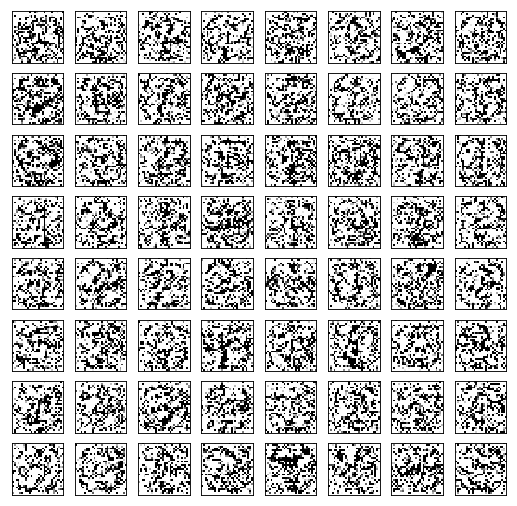

Iteration 1122000: loss=0.00010327027121093124
Iteration 1124000: loss=0.0001032568616210483
Iteration 1126000: loss=0.00010324533650418743
Iteration 1128000: loss=0.0001032358268275857
Iteration 1130000: loss=0.00010322799062123522
Iteration 1132000: loss=0.00010322119487682357
Iteration 1134000: loss=0.00010321498848497868
Iteration 1136000: loss=0.00010320911678718403
Iteration 1138000: loss=0.00010320360161131248
Iteration 1140000: loss=0.00010319845023332164


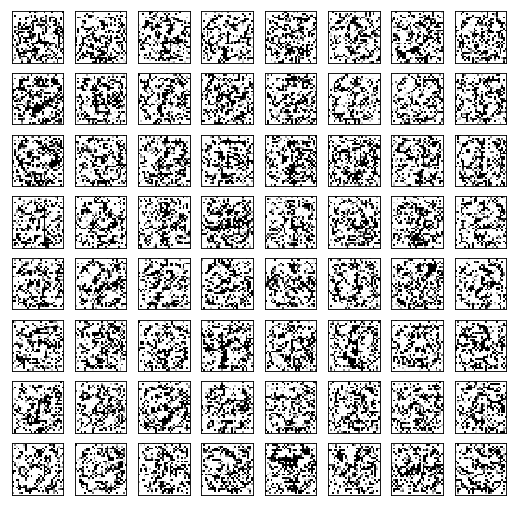

Iteration 1142000: loss=0.00010319326975150034
Iteration 1144000: loss=0.00010318804561393335
Iteration 1146000: loss=0.00010318274871679023
Iteration 1148000: loss=0.00010317695705452934
Iteration 1150000: loss=0.00010317069973098114
Iteration 1152000: loss=0.0001031634965329431
Iteration 1154000: loss=0.00010315480903955176
Iteration 1156000: loss=0.00010314521205145866
Iteration 1158000: loss=0.00010313607344869524
Iteration 1160000: loss=0.00010312855010852218


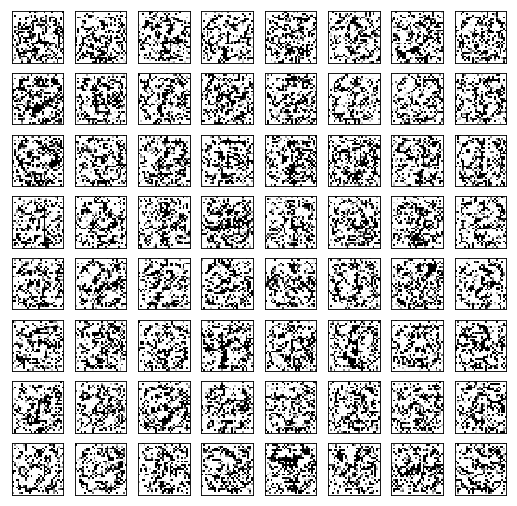

Iteration 1162000: loss=0.00010312225640518591
Iteration 1164000: loss=0.00010311674850527197
Iteration 1166000: loss=0.00010311160440323874
Iteration 1168000: loss=0.00010310713696526363
Iteration 1170000: loss=0.00010310292418580502
Iteration 1172000: loss=0.00010309889330528677
Iteration 1174000: loss=0.00010309500066796318
Iteration 1176000: loss=0.0001030915227602236
Iteration 1178000: loss=0.00010308809578418732
Iteration 1180000: loss=0.00010308474884368479


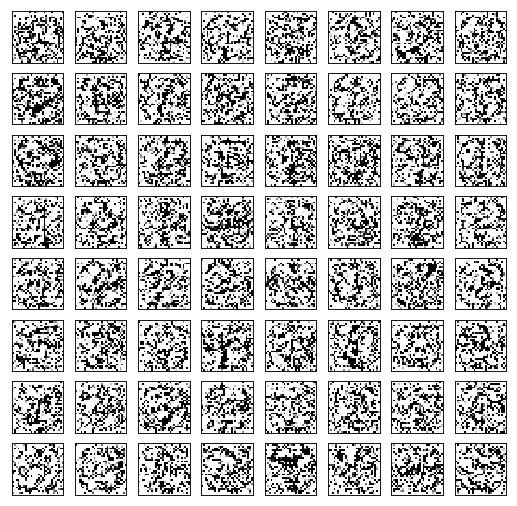

Iteration 1182000: loss=0.00010308154742233455
Iteration 1184000: loss=0.00010307842603651807
Iteration 1186000: loss=0.00010307571210432798
Iteration 1188000: loss=0.00010307269258191809
Iteration 1190000: loss=0.00010307002230547369
Iteration 1192000: loss=0.0001030670537147671
Iteration 1194000: loss=0.00010306426702300087
Iteration 1196000: loss=0.00010306159674655646
Iteration 1198000: loss=0.00010305902105756104
Iteration 1200000: loss=0.00010305647447239608


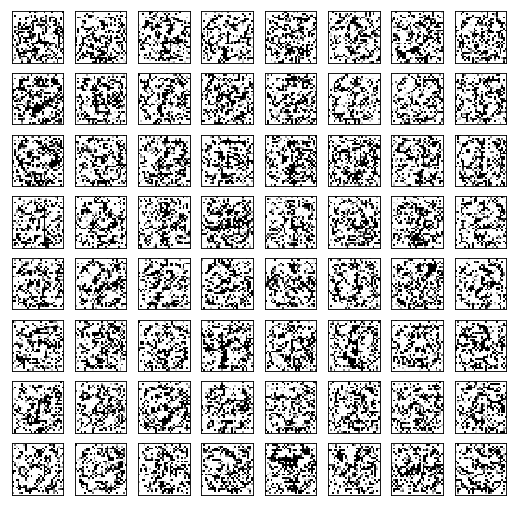

Iteration 1202000: loss=0.00010305381147190928
Iteration 1204000: loss=0.00010305122850695625
Iteration 1206000: loss=0.00010304873285349458
Iteration 1208000: loss=0.00010304621537216008
Iteration 1210000: loss=0.00010304382885806262
Iteration 1212000: loss=0.00010304131865268573
Iteration 1214000: loss=0.0001030388375511393
Iteration 1216000: loss=0.00010303624731022865
Iteration 1218000: loss=0.00010303388262400404
Iteration 1220000: loss=0.0001030314524541609


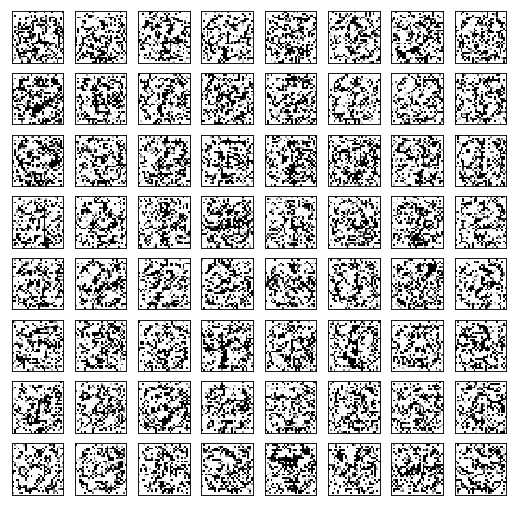

Iteration 1222000: loss=0.00010302889859303832
Iteration 1224000: loss=0.00010302635928383097
Iteration 1226000: loss=0.00010302364535164088
Iteration 1228000: loss=0.00010302099690306932
Iteration 1230000: loss=0.00010301846486981958
Iteration 1232000: loss=0.00010301574366167188
Iteration 1234000: loss=0.00010301302245352417
Iteration 1236000: loss=0.00010301034490112215
Iteration 1238000: loss=0.00010300755820935592
Iteration 1240000: loss=0.00010300461872247979


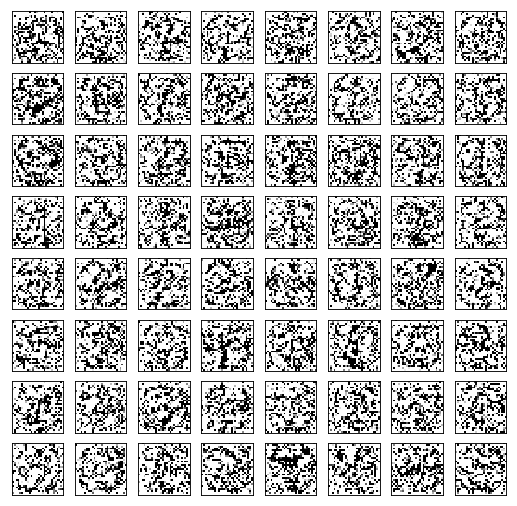

Iteration 1242000: loss=0.0001030017519951798
Iteration 1244000: loss=0.00010299878340447322
Iteration 1246000: loss=0.00010299584391759709
Iteration 1248000: loss=0.00010299300629412755
Iteration 1250000: loss=0.00010299021960236132
Iteration 1252000: loss=0.0001029872873914428
Iteration 1254000: loss=0.0001029846171149984
Iteration 1256000: loss=0.00010298169945599511
Iteration 1258000: loss=0.00010297888366039842
Iteration 1260000: loss=0.00010297592234564945


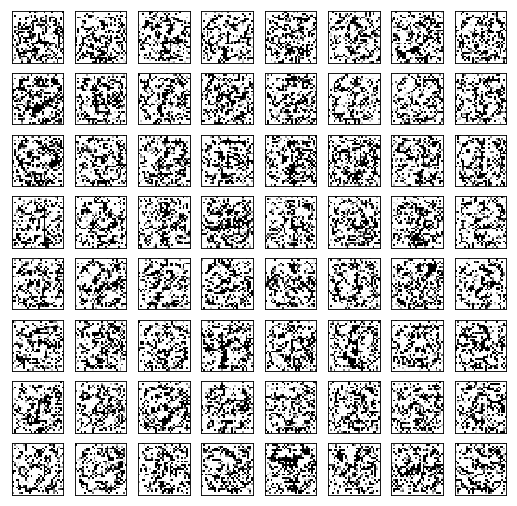

Iteration 1262000: loss=0.00010297292465111241
Iteration 1264000: loss=0.00010296988330082968
Iteration 1266000: loss=0.00010296661639586091
Iteration 1268000: loss=0.0001029630730045028
Iteration 1270000: loss=0.00010295905667589977
Iteration 1272000: loss=0.00010295422544004396
Iteration 1274000: loss=0.00010294875391991809
Iteration 1276000: loss=0.00010294200910720974
Iteration 1278000: loss=0.00010293442028341815
Iteration 1280000: loss=0.00010292655497323722


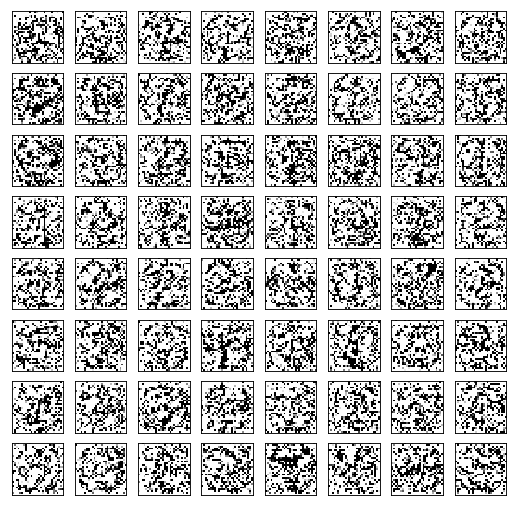

Iteration 1282000: loss=0.00010291900980519131
Iteration 1284000: loss=0.00010291230864822865
Iteration 1286000: loss=0.00010290653153788298
Iteration 1288000: loss=0.00010290139471180737
Iteration 1290000: loss=0.00010289667261531577
Iteration 1292000: loss=0.00010289250349160284
Iteration 1294000: loss=0.00010288875637343153
Iteration 1296000: loss=0.00010288511839462444
Iteration 1298000: loss=0.00010288182966178283
Iteration 1300000: loss=0.00010287846089340746


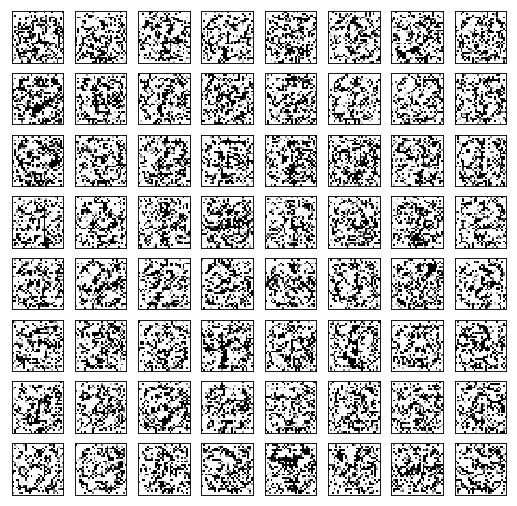

Iteration 1302000: loss=0.00010287526674801484
Iteration 1304000: loss=0.00010287224722560495
Iteration 1306000: loss=0.00010286923497915268
Iteration 1308000: loss=0.00010286625911248848
Iteration 1310000: loss=0.00010286332690156996
Iteration 1312000: loss=0.00010286020551575348
Iteration 1314000: loss=0.00010285727330483496
Iteration 1316000: loss=0.0001028542683343403
Iteration 1318000: loss=0.00010285119788022712
Iteration 1320000: loss=0.00010284809104632586


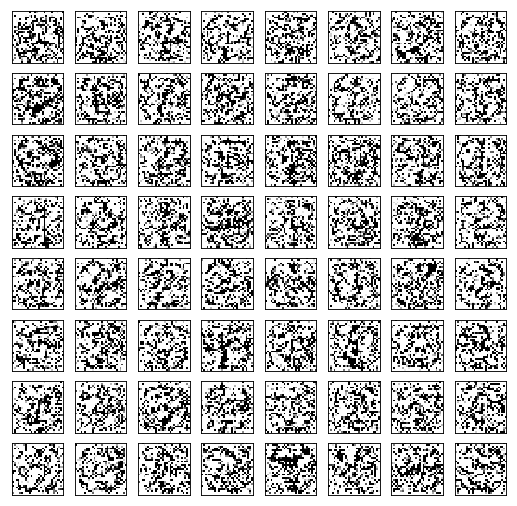

Iteration 1322000: loss=0.00010284504242008552
Iteration 1324000: loss=0.00010284176096320152
Iteration 1326000: loss=0.00010283868323313072
Iteration 1328000: loss=0.00010283556184731424
Iteration 1330000: loss=0.00010283259325660765
Iteration 1332000: loss=0.00010282954463036731
Iteration 1334000: loss=0.00010282650328008458
Iteration 1336000: loss=0.00010282335279043764
Iteration 1338000: loss=0.00010282023868057877
Iteration 1340000: loss=0.00010281681170454249


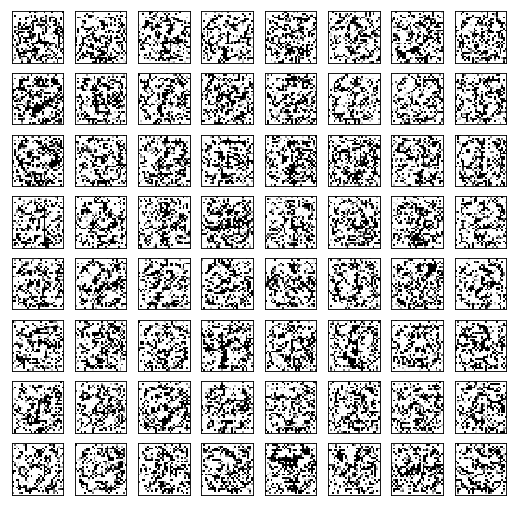

Iteration 1342000: loss=0.00010281311551807448
Iteration 1344000: loss=0.00010280909918947145
Iteration 1346000: loss=0.00010280439164489508
Iteration 1348000: loss=0.0001027983526000753
Iteration 1350000: loss=0.00010279016714775935
Iteration 1352000: loss=0.00010277929686708376
Iteration 1354000: loss=0.00010276625835103914
Iteration 1356000: loss=0.00010275354725308716
Iteration 1358000: loss=0.00010274358646711335
Iteration 1360000: loss=0.00010273565567331389


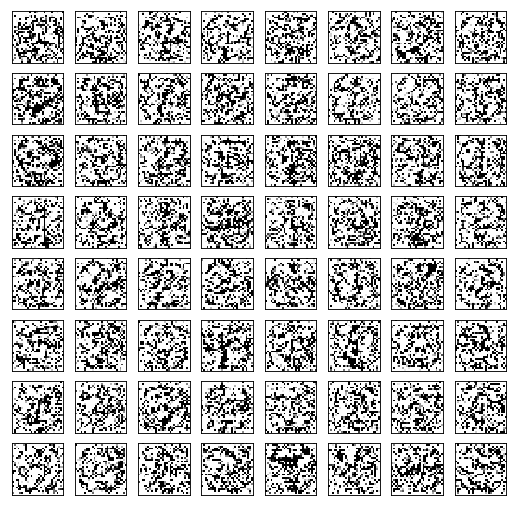

Iteration 1362000: loss=0.00010272913641529158
Iteration 1364000: loss=0.00010272373765474185
Iteration 1366000: loss=0.00010271844075759873
Iteration 1368000: loss=0.0001027135003823787
Iteration 1370000: loss=0.00010270880011375993
Iteration 1372000: loss=0.00010270388884237036
Iteration 1374000: loss=0.00010269889025948942
Iteration 1376000: loss=0.00010269334597978741
Iteration 1378000: loss=0.0001026874451781623
Iteration 1380000: loss=0.00010268091136822477


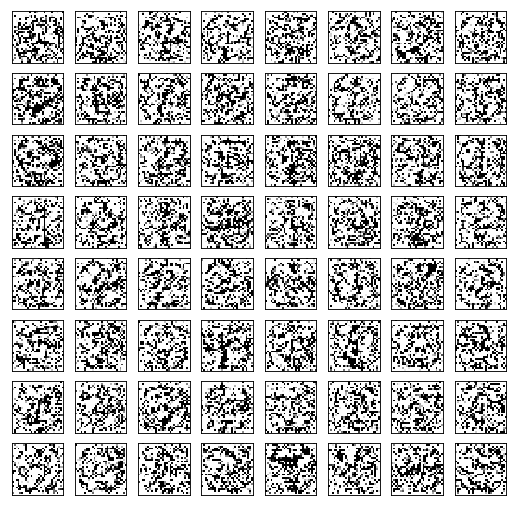

Iteration 1382000: loss=0.0001026739992084913
Iteration 1384000: loss=0.0001026669197017327
Iteration 1386000: loss=0.00010266019671689719
Iteration 1388000: loss=0.00010265364107908681
Iteration 1390000: loss=0.00010264746379107237
Iteration 1392000: loss=0.00010264161392115057
Iteration 1394000: loss=0.00010263625154038891
Iteration 1396000: loss=0.00010263094736728817
Iteration 1398000: loss=0.00010262591968057677
Iteration 1400000: loss=0.0001026211102725938


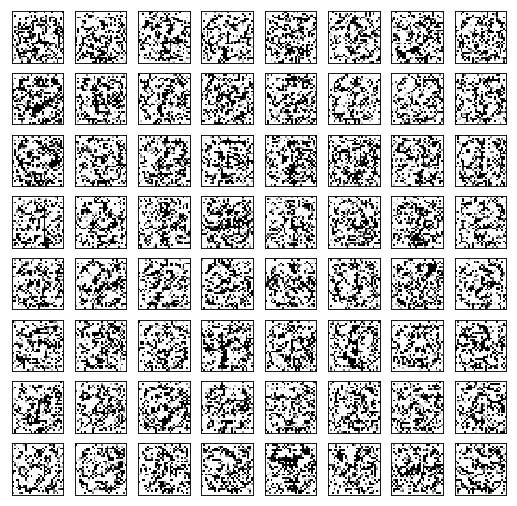

Iteration 1402000: loss=0.0001026167010422796
Iteration 1404000: loss=0.00010261247371090576
Iteration 1406000: loss=0.00010260839917464182
Iteration 1408000: loss=0.00010260470298817381
Iteration 1410000: loss=0.00010260091221425682
Iteration 1412000: loss=0.00010259744885843247
Iteration 1414000: loss=0.00010259411646984518
Iteration 1416000: loss=0.00010259081318508834
Iteration 1418000: loss=0.00010258773545501754
Iteration 1420000: loss=0.00010258477414026856


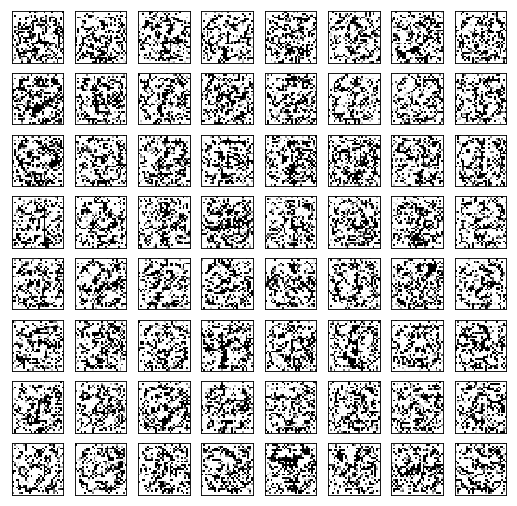

Iteration 1422000: loss=0.00010258200927637517
Iteration 1424000: loss=0.0001025792007567361
Iteration 1426000: loss=0.00010257644316880032
Iteration 1428000: loss=0.00010257393296342343
Iteration 1430000: loss=0.00010257137910230085
Iteration 1432000: loss=0.00010256905807182193
Iteration 1434000: loss=0.00010256678069708869
Iteration 1436000: loss=0.00010256429959554225
Iteration 1438000: loss=0.00010256223322357982
Iteration 1440000: loss=0.00010256007954012603


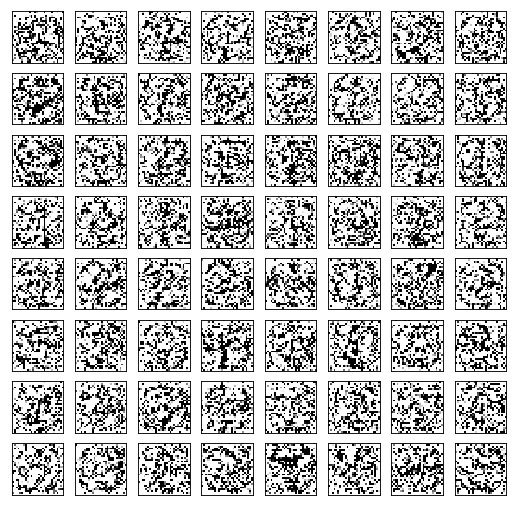

Iteration 1442000: loss=0.00010255792585667223
Iteration 1444000: loss=0.00010255583765683696
Iteration 1446000: loss=0.00010255394590785727
Iteration 1448000: loss=0.00010255198867525905
Iteration 1450000: loss=0.00010254995140712708
Iteration 1452000: loss=0.00010254805238218978
Iteration 1454000: loss=0.00010254618973704055
Iteration 1456000: loss=0.0001025443198159337
Iteration 1458000: loss=0.00010254266817355528
Iteration 1460000: loss=0.00010254100197926164


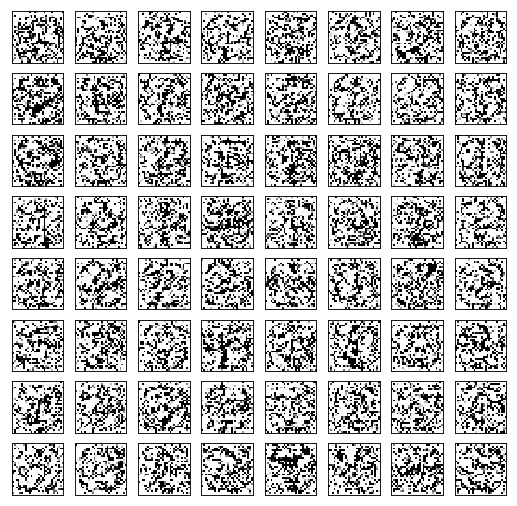

Iteration 1462000: loss=0.00010253908112645149
Iteration 1464000: loss=0.00010253722575725988
Iteration 1466000: loss=0.00010253561777062714
Iteration 1468000: loss=0.00010253398795612156
Iteration 1470000: loss=0.0001025323144858703
Iteration 1472000: loss=0.0001025307719828561
Iteration 1474000: loss=0.00010252902575302869
Iteration 1476000: loss=0.00010252750507788733
Iteration 1478000: loss=0.00010252585343550891
Iteration 1480000: loss=0.00010252424544887617


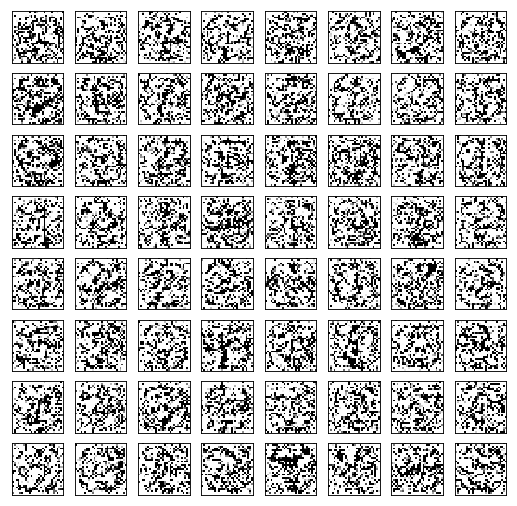

Iteration 1482000: loss=0.00010252268111798912
Iteration 1484000: loss=0.00010252124047838151
Iteration 1486000: loss=0.00010251982166664675
Iteration 1488000: loss=0.00010251813364448026
Iteration 1490000: loss=0.00010251669300487265
Iteration 1492000: loss=0.00010251524508930743
Iteration 1494000: loss=0.00010251380444969982
Iteration 1496000: loss=0.00010251227649860084
Iteration 1498000: loss=0.00010251106868963689
Iteration 1500000: loss=0.00010250959894619882


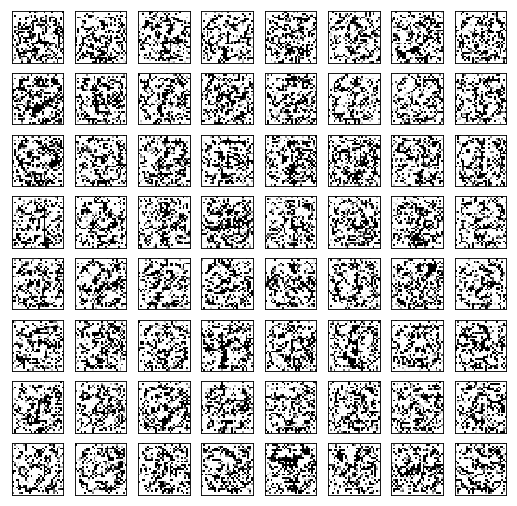

Iteration 1502000: loss=0.00010250798368360847
Iteration 1504000: loss=0.00010250663035549223
Iteration 1506000: loss=0.00010250521154375747
Iteration 1508000: loss=0.00010250381455989555
Iteration 1510000: loss=0.00010250257764710113
Iteration 1512000: loss=0.0001025012752506882
Iteration 1514000: loss=0.0001024997909553349
Iteration 1516000: loss=0.00010249852493871003
Iteration 1518000: loss=0.00010249699698761106
Iteration 1520000: loss=0.00010249581828247756


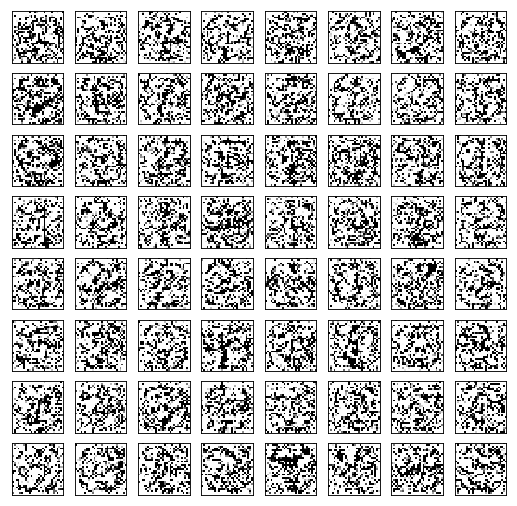

Iteration 1522000: loss=0.00010249449405819178
Iteration 1524000: loss=0.00010249308979837224
Iteration 1526000: loss=0.00010249162005493417
Iteration 1528000: loss=0.0001024903540383093
Iteration 1530000: loss=0.0001024890152621083
Iteration 1532000: loss=0.00010248782200505957
Iteration 1534000: loss=0.00010248657054034993
Iteration 1536000: loss=0.00010248524631606415
Iteration 1538000: loss=0.00010248389298794791
Iteration 1540000: loss=0.00010248253965983167


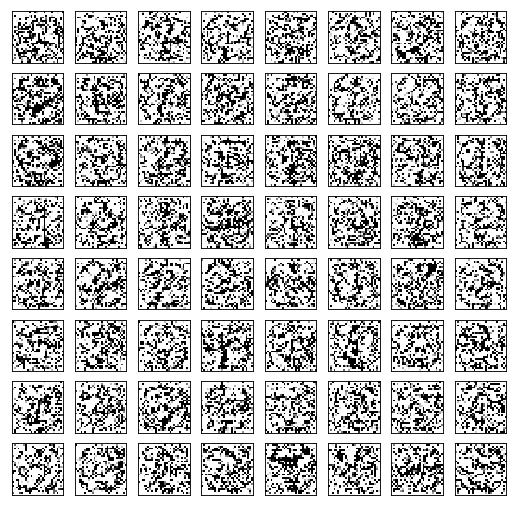

Iteration 1542000: loss=0.00010248125181533396
Iteration 1544000: loss=0.00010247995669487864
Iteration 1546000: loss=0.00010247858881484717
Iteration 1548000: loss=0.00010247725731460378
Iteration 1550000: loss=0.00010247585305478424
Iteration 1552000: loss=0.00010247457248624414
Iteration 1554000: loss=0.00010247311001876369
Iteration 1556000: loss=0.00010247176396660507
Iteration 1558000: loss=0.0001024703451548703
Iteration 1560000: loss=0.00010246887541143224


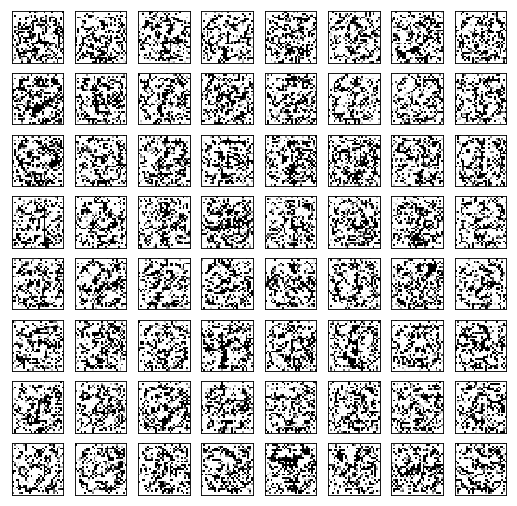

Iteration 1562000: loss=0.00010246730380458757
Iteration 1564000: loss=0.00010246575402561575
Iteration 1566000: loss=0.00010246420424664393
Iteration 1568000: loss=0.0001024624434649013
Iteration 1570000: loss=0.00010246060264762491
Iteration 1572000: loss=0.00010245856537949294
Iteration 1574000: loss=0.00010245670273434371
Iteration 1576000: loss=0.00010245465819025412
Iteration 1578000: loss=0.00010245259909424931
Iteration 1580000: loss=0.00010245056910207495


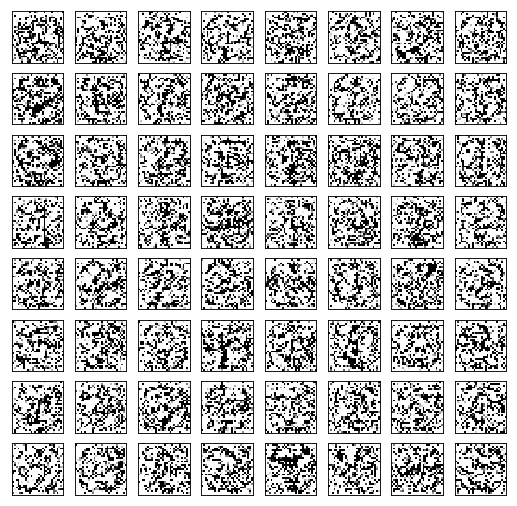

Iteration 1582000: loss=0.00010244861186947674
Iteration 1584000: loss=0.0001024468001560308
Iteration 1586000: loss=0.00010244486475130543
Iteration 1588000: loss=0.00010244297300232574
Iteration 1590000: loss=0.00010244147415505722
Iteration 1592000: loss=0.00010243990982417017
Iteration 1594000: loss=0.00010243825090583414
Iteration 1596000: loss=0.00010243673023069277
Iteration 1598000: loss=0.00010243510769214481
Iteration 1600000: loss=0.00010243353608530015


In [ ]:
new_image_batch = generate_image(img)

In [ ]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
print (new_image_batch.shape)
print (new_image_batch)

In [ ]:
latent = model.E(new_image_batch.view(-1, 28*28))
print (latent.shape)
print (latent)

### Генерация изображений из шума

In [ ]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
new_image_randn = generate_image(img)

In [ ]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
print (new_image_randn.shape)
print (new_image_randn)

In [ ]:
latent = model.E(new_image_randn.view(-1, 28*28))
print (latent.shape)
print (latent)